In [1]:
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
import math
import cmath
import scipy
import scipy.interpolate as interpolate
import scipy.integrate as integrate
import scipy.special as special
import numpy.ma as ma
#np.set_printoptions(threshold=sys.maxsize)
pts = 5000 # number of iterator steps where neccessary
H_to_K = 1/0.000003166808534191 # conversion of Henries to Kelvin
tol = 1e-6 # tolerance where neccessary

In [2]:
R1 = 4.5 # starting posistion r1 in ao
R2 = 700 # ending posistion r2 in ao
dr1 = 0.02 # step spacing in ao

N_big = int((R2-R1)/dr1)
ipap_big = np.arange(1,N_big, 1.0)
R_grid = R1 + dr1*ipap_big

#dr2 = 0.02
#r3 = 500

#dr3 = 0.02
#r4 = 700
#N1 = int((r2-r1)/dr1) # Number of grid points
#Np = int((r3-r1)/dr2) # Number of grid points


#ipap = np.arange(1,N1, 1.0) # indexing from the paper, given i = 1,2,...,N-1
#ipap_p = np.arange(1,Np, 1.0) # indexing from the paper, given i = 1,2,...,N-1
#ipap_pp = np.arange(1,Npp, 1.0)

#r = r1 + dr1*ipap
#rp = r1 + dr2*ipap_p
#rpp = r1 + dr3*ipap_pp
#print(len(rpp))


C12 = 3.05e8 # C12 coefficient in Eh*ao
C6 = 4710 # C6 coefficient in Eh*ao
C6p = 4e6 # C6' coefficient in Eh*ao
C3 = 20 # C3 coefficient in Eh*ao

VLJ = (C12/(R_grid**12)) - (C6/(R_grid**6)) # standard Lennard-Jones interatomic potential
VE = (C6p*(1/(R_grid**6))) - (C3*(1/(R_grid**3)))

Eo = 3.166808534191e-12 # inital particle energy, 1uK in Hartrees
me = 9.1093837e-28 # electron mass in grams
mrb_g = 1.4192261e-22 # rubidium mass in grams
mrb = mrb_g/me # rubidium mass in au
mu = (mrb**2)/(2*mrb) # reduced mass of rubidium
hbar = 1.0546e-27 # reduced Planck constant in cgs
e = 4.8032e-10 # electron charge in cgs
ao = (hbar**2)/(me*e**2) # Bohr radius in cgs

# Ground State --- Lennard-Jones
## $V(r) = \frac{C_{12}}{r^{12}} - \frac{C_{6}}{r^{6}}$
## $C_{12} = 3.05\times10^{8} E_{h}a_{0}$, $C_{6} = 4710 E_{h}a_{0}$

#  $ 1^{st} $ Excited State --- C3 thing 
## $V_E(r) = \frac{C_{6}'}{r^{6}} - \frac{C_{3}}{r^{3}}$
## $C_{6}' = 4\times10^{6} E_{h}a_{0}$, $C_{3} = 20 E_{h}a_{0}$

 Number of points in large grid = 34775


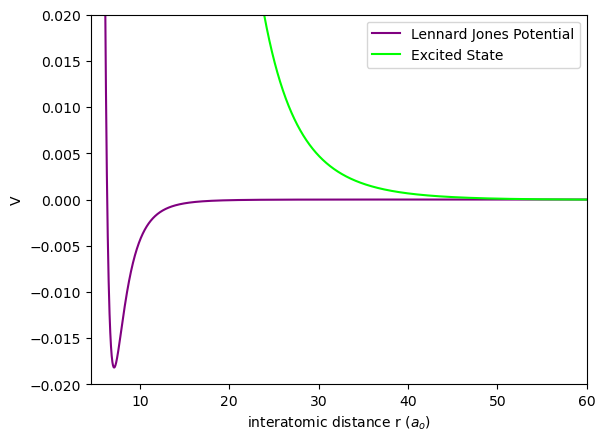

In [5]:
plt.plot(R_grid, VLJ, color = 'purple', label = 'Lennard Jones Potential')
plt.plot(R_grid, VE, color = 'lime', label = 'Excited State')
plt.ylabel('V')
plt.xlabel('interatomic distance r $(a_o)$')
plt.legend()
plt.ylim(-0.02,0.02)
plt.xlim(R1,60)

print(f' Number of points in large grid = {N_big}')

(4.0, 150.0)

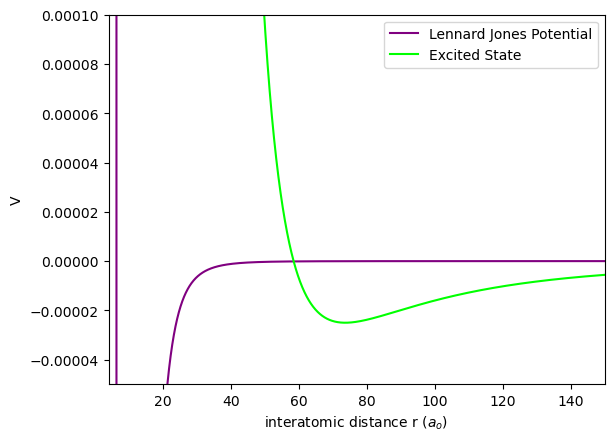

In [6]:
plt.plot(R_grid, VLJ, color = 'purple', label = 'Lennard Jones Potential')
plt.plot(R_grid, VE, color = 'lime', label = 'Excited State')
plt.ylabel('V')
plt.xlabel('interatomic distance r $(a_o)$')
plt.legend()
plt.ylim(-5e-5,10e-5)
plt.xlim(4,150)


# Scattering States of the Lennard Jones Potential
# Energy Normalization
## $(\psi_{N}(R_2))^2 + (\frac{1}{k}\psi_{N}'(R_2))^2 = U^2$
## $\Psi_{E} = \frac{\psi_N}{U}\sqrt{\frac{2\mu}{\pi k}} $

In [8]:
def Numerov(Energy, Num, V_r, dr, grid): # function to find psi(r) continuum state (E>0)
    psi[0] = 0 # impose boundary condition psi(0) = 0
    psi[1] = dr # let psi(1) = the spacing length
    #print(f' psi[1] = {psi[1]}')
    ksq = 2*mu*(Energy - V_r) # wave number squared for the energy
    ksq_p = 2*mu*Energy

    for i in range(2,Num):  # Numerov Algorithm, range is 2 -> N since psi(0), psi(1) already set
        #if i < 100:
           # print(f' first term in numerator is {(2*(1 - (5/12)*(dr**2)*ksq[i-1])*psi[i-1])}')
           # print(f' the numerator is {((2*(1 - (5/12)*(dr**2)*ksq[i-1])*psi[i-1]) - ((1 + (1/12)*(dr**2)*ksq[i-2])*psi[i-2]))}')
        psi[i] = ((2*(1 - (5/12)*(dr**2)*ksq[i-1])*psi[i-1]) - ((1 + (1/12)*(dr**2)*ksq[i-2])*psi[i-2]))/(1 + (1/12)*(dr**2)*ksq[i])
    Psi_f = psi/max(psi) # divide Psi by its largest value to qvoid it becoming too large
    Psi_prime = np.gradient(Psi_f, grid) # find the derivate over the grid r
    
    # Energy Normalization
    A_term = Psi_f[-1]**2
    B_term = Psi_prime[-1]**2
    B_coef = 1/(ksq[-1])
    U_sq = A_term + B_coef*B_term
    U = np.sqrt(U_sq)
    norm_factor = np.sqrt((2*mu)*(1/(np.pi*np.sqrt(ksq[-1]))))
    #print((U,norm_factor))
    
    Psi_Energy_Normalized = (1/U)*(Psi_f)*norm_factor
    
        
    return Psi_Energy_Normalized

(4.0, 700.0)

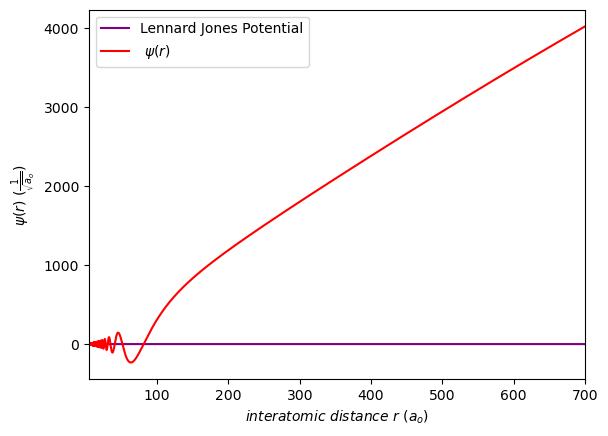

In [9]:
VLJ = (C12/(R_grid**12)) - (C6/(R_grid**6))
psi = np.zeros(N_big-1)  # initializing psi(r) as array of zeros
Psi_1 = Numerov(Eo, N_big-1, VLJ, dr1, R_grid) # wave function Psi
#plt.plot(r, Psi_1, label = f' $\\psi(r)$', color = 'red') 
plt.plot(R_grid, VLJ, color = 'purple', label = 'Lennard Jones Potential')

psi_1prime = np.gradient(Psi_1, R_grid) # first posistion derivate of wave function Psi
plt.plot(R_grid, Psi_1, label = f' $\\psi(r)$', color = 'red') 
#plt.plot(r, Vr*1e0, label = 'Scaled Lennard-Jones Potential', color = 'purple')
plt.xlabel('$ interatomic$ $distance$ $r$ $(a_{o})$')
plt.ylabel('$\\psi(r)$ ($\\frac{1}{\\sqrt{a_{o}}}$)')
plt.legend()

#plt.ylim(-0.02,0.045)
#plt.ylim(-0.001,0.001)
plt.xlim(4,R2)

In [10]:
VLJ = (C12/(R_grid**12)) - (C6/(R_grid**6))
psi = np.zeros(N_big-1)  # initializing psi(r) as array of zeros
Psi_1 = Numerov(Eo, N_big-1, VLJ, dr1, R_grid) # wave function Psi
#plt.plot(R_grid, Psi_1, label = f' $\\psi(r)$', color = 'red') 
#plt.plot(R_grid, VLJ, color = 'purple', label = 'Lennard Jones Potential')


#psi_1prime = np.gradient(Psi_1, R_grid) # first posistion derivate of wave function Psi
#plt.plot(rpp, Psi_1, label = f' $\\psi(r)$', color = 'red') 
#plt.plot(r, Vr*1e0, label = 'Scaled Lennard-Jones Potential', color = 'purple')
#plt.xlabel('$ interatomic$ $distance$ $r$ $(a_{o})$')
#plt.ylabel('$\\psi(r)$ ($\\frac{1}{\\sqrt{a_{o}}}$)')
#plt.legend()

#plt.ylim(-20,35)
#plt.xlim(6,14)

# Bound States of Excited Potential

In [12]:
def Hamiltonian_DVR(a, b, dx): # DVR method for finding bound states
    N = int((b-a)/dx) # Number of grid points
    ipaper = np.arange(1,N, 1.0) # indexing from the paper, given i = 1,2,...,N-1
    x = a + dx*ipaper # grid from paper
    Vx = C6p/(x**6) - C3/(x**3) # Lennard-Jones potential
    Vx = np.insert(Vx,0,0) # Insert a 0 at the 0th index of list to account for mismatched indexing

    #print(f' ipaper = {ipaper}')
    #print(f' x = {x}')
    print(f' N - 1 = {N-1}')
    #print(f' len(x) = {len(x)}')
    #print(x[-1]/(b-dx))
    #print(x[0]/(a+dx))
    #print(f' dx = {dx}')
    #print(f'dx from grid  = {x[1] - x[0]}')
    #print(Vx[len(Vx) - 1]/(0.5*(b - dx - d)**2))

    H_DVR = np.zeros((len(x), len(x))) # Initialize empty Hamiltonian matrix of size N-1 x N-1
    Vmat = np.zeros((len(x) + 10, len(x) + 10))
    Tmat = np.zeros((len(x) + 10, len(x) + 10))


    for i in ipaper:
        for j in ipaper:
            if int(i) == int(j): # fill in diagonal components of the Hamiltonian
                prefactorii = (np.pi**2)/(4*mu*(b-a)**2)
                bracketii = ((2*N**2 + 1)/3) - (1/((np.sin(np.pi*(i/N)))**2))
                
                Tmat[int(i)][int(j)] = prefactorii*bracketii
                Vmat[int(i)][int(j)] = Vx[int(j)]
                
                H_DVR[int(i) - 1][int(j) - 1] = Tmat[int(i)][int(j)] + Vmat[int(i)][int(j)]
            
            if i != j: # fill in off-diagonal components of the Hamiltonian
                diff = i - j
                prefactorij = ((-1)**(diff))*(np.pi**2)/(4*mu*(b-a)**2)
                bracketij = (1/((np.sin(np.pi*((diff)/(2*N))))**2)) - (1/((np.sin(np.pi*((i+j)/(2*N))))**2))
                Tmat[int(i)][int(j)] = prefactorij*bracketij               
                
                H_DVR[int(i) - 1][int(j) - 1] = Tmat[int(i)][int(j)]
                
    #assert(np.allclose(H_DVR, np.transpose(H_DVR)))
    #print(f' H = {H}')
    return H_DVR

In [13]:
r1_i = 1898 # index of r1 in larger grid
r2_i = 14775 # index of r2 in larger grid

r1 = R_grid[r1_i] # 42.5ao, smaller grid starting posistion
r2 = R_grid[r2_i] # 300ao, larger grid ending posistion
print((r1, r2))

N_small = int((r2 - r1)/dr1) # number of points in smaller grid
ipap_p = np.arange(1,N_small, 1.0) # DVR paper indexing for smaller grid
r_grid = r1 + dr1*ipap_p # sub grid to calculate DVR and FC factor on

H = Hamiltonian_DVR(r1, r2, dr1) # Hamiltonian to construct excited potential bound states

(42.480000000000004, 300.02)
 N - 1 = 12875


In [14]:
# Find eigenvals/vecs of Hamilitonian

Heig = np.linalg.eigh(H)[0] # eigenvalues of Hamilitonian
print(f'there are {len(Heig[Heig < 0])} bound states') 

Eigvec = np.linalg.eigh(H)[1]
Hvec = []
for i in range(len(H[0])):
    avec = Eigvec[:,i]
    Hvec.append(avec)

there are 69 bound states


In [15]:
# Normalize eigenvectors

for i in range(len(Hvec)):
    INT = np.trapz(np.abs(Hvec[i])**2,r_grid)
    A = 1/np.sqrt(INT)
    Hvec[i] = A*Hvec[i]

[-2.44878074e-05 -2.34890698e-05 -2.25223582e-05 -2.15869648e-05
 -2.06821886e-05 -1.98073350e-05 -1.89617165e-05 -1.81446527e-05
 -1.73554698e-05 -1.65935016e-05 -1.58580889e-05 -1.51485801e-05
 -1.44643307e-05 -1.38047041e-05 -1.31690713e-05 -1.25568109e-05
 -1.19673095e-05 -1.13999616e-05 -1.08541698e-05 -1.03293447e-05
 -9.82490517e-06 -9.34027845e-06 -8.87490007e-06 -8.42821405e-06
 -7.99967294e-06 -7.58873788e-06 -7.19487869e-06 -6.81757393e-06
 -6.45631096e-06 -6.11058598e-06]


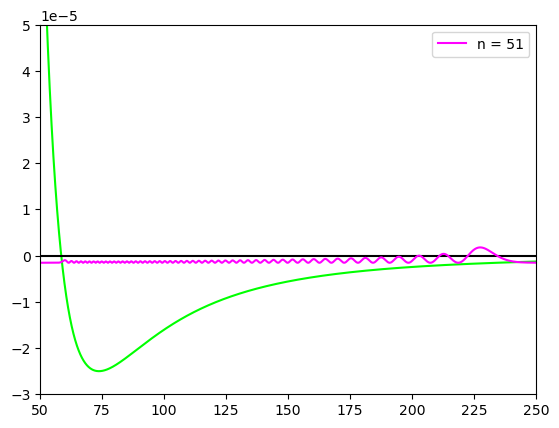

In [16]:
# Plot scaled eigenvectors + eigenvalues on top of potential

V1excited = C6p/(r_grid**6) - C3/(r_grid**3)
plt.plot(r_grid, V1excited, color = 'lime')
plt.hlines(0, r1, R2, color = 'black')

for i in range(len(Heig[Heig < 0])):
 #   if i % 5 == 0:
  #      plt.plot(rp, 0.0005*np.abs(Hvec[i])**2 + Heig[i])
    if i == 51:
        plt.plot(r_grid, 0.0001*np.abs(Hvec[i])**2 + Heig[i], color = 'fuchsia', label = f'n = {i}')
plt.legend()
plt.ylim(-3e-5,5e-5)
plt.xlim(50,250)
#plt.xlim(50,70)
print(Heig[0:30])

In [17]:
Bound_States = np.arange(0,51,1)

# There are at least 51 bound states

In [19]:
# Check that all bound states are orthonormal

for i in range(len(Heig[Heig < 0])): # run through all eigenvectors corresponding to bound states
    for j in range(len(Heig[Heig < 0])): # run through all other eigenvectors corresponding to bound states
        
        if i == j: # inner product should be close to 1
            phi_n = np.conjugate(Hvec[i])
            phi_m = Hvec[j]
            produit = phi_n*phi_m
            InnerProduct = np.trapz(produit, r_grid)
            assert(InnerProduct - 1 <= tol)

        if i != j: # inner product should be close to 0
            phi_n = np.conjugate(Hvec[i])
            phi_m = Hvec[j]
            produit = phi_n*phi_m
            InnerProduct = np.trapz(produit, r_grid)
            assert(InnerProduct <= tol)

# Inner product between bound excited state wave functions and continuum ground state scattering wave functions

# Franck-Condon Factor
## $ \braket{\varphi_{b}|\psi_{s}}  = \int_{r1}^{r2} \varphi^*_{b}\psi_{s}\,dr$

In [22]:
PHI_B = np.conjugate(Hvec[0])
Psi_FC = Psi_1[r1_i + 1:r2_i - 1]
Integrand = PHI_B*Psi_FC
Inner_Product = np.trapz(Integrand, r_grid)
print(Inner_Product)

-397.89901203045963


## NEXT: 
### 1.) Vary bound states with in FC factor and see if there is a trend (choose different bound state for the same scattering state)

In [24]:
FC_factors = []
for i in range(len(Heig[Heig<0])):
    PHI_B = np.conjugate(Hvec[i])
    Psi_FC = Psi_1[r1_i + 1:r2_i - 1]
    Integrand = PHI_B*Psi_FC
    Inner_Product = np.trapz(Integrand, r_grid)
    FC_factors.append(Inner_Product)
    
#print(FC_factors)

In [25]:
#plt.scatter(np.arange(1, len(Heig[Heig<0]) +1), FC_factors, color = 'orange')
#plt.xlabel('Energy Bound State $ \\phi_n $')
#plt.ylabel(' Franck-Condon Factor')

In [26]:
#plt.hlines(0, min(r_grid), max(r_grid), color = 'black')
#plt.plot(r_grid, Psi_1[r1_i + 1:r2_i - 1], color = 'red', label = 'scattering state')
for i in range(len(Heig[Heig<0])):
    if i == 4:
        PHI_B = np.conjugate(Hvec[i])
 #       plt.plot(r_grid, PHI_B, color = 'fuchsia', label = f'bound state n = {i+1}')

##plt.xlabel('interatomic distance r $(a_o)$')
#plt.ylabel('wave function')
#plt.legend()

#plt.xlim(min(r_grid),max(r_grid))

In [27]:
#plt.hlines(0, min(r_grid), max(r_grid), color = 'black')
#plt.plot(r_grid, Psi_1[r1_i + 1:r2_i - 1], color = 'red', label = 'scattering state')
#for i in range(len(Heig[Heig<0])):
#    if i == 9:
 #       PHI_B = np.conjugate(Hvec[i])
 #       plt.plot(r_grid, PHI_B, color = 'fuchsia', label = f'bound state n = {i+1}')

#plt.xlabel('interatomic distance r $(a_o)$')
#plt.ylabel('wave function')
#plt.legend()

#plt.xlim(min(r_grid),110)
#plt.hlines(0, min(rppp), max(rppp), color = 'black')

In [28]:
#plt.hlines(0, min(r_grid), max(r_grid), color = 'black')
#plt.plot(rppp, Psi_1[r1_i + 1:r2_i - 1], color = 'red', label = 'scattering state')
#for i in range(len(Heig[Heig<0])):
 #   if i == 9:
 #       PHI_B = np.conjugate(Hvec[i])
 #       plt.plot(r_grid, PHI_B*Psi_1[r1_i + 1:r2_i - 1], color = 'darkorange', label = f' n = {i+1}')

#plt.xlabel('interatomic distance r $(a_o)$')
#plt.ylabel('$ \\varphi^*_{b} \\psi_{s}$')
#plt.legend()

#plt.xlim(min(r_grid),120)
#plt.hlines(0, min(rppp), max(rppp), color = 'black')

### 2.) Vary scattering length (C12 coefficient) to see the effect on a paticular bound state (Vary the C12 coefficient in the LJ potential and compare FC factor for the same excited bound state)

# C12 coefs close together, C12 from 1.101e8Ehao $→$ 1.107e8Ehao, $a_s$ from 173ao $→$ 3287ao

In [31]:
#wiuniuwniofqe for oi akp

In [32]:
#scattering_lengths = [23.118272010998865, 23.294772927224223, 23.47102188863188, 23.647187978773193, 23.823426831925502, 23.999405940636574, 24.17522106780508, 24.35119330384819, 24.52683040828181, 24.7025339096497, 24.87794230404325, 25.05351626848902, 25.22866799412433, 25.403976102477202, 25.57906016985038, 25.75399709786118, 25.929167925228914, 26.103819650298952, 26.278536474522717, 26.45327416041281, 26.627741622053176, 26.80232713591603, 26.97670560569878, 27.150975587506338, 27.32525972628038, 27.499381777965485, 27.673407128668362, 27.8474624862435, 28.02125296431039, 28.195077301795596, 28.369020984121608, 28.542667703266964, 28.71626195545282, 28.889754036799854, 29.063166197506348, 29.23663270593716, 29.409967512225727, 29.58322412500383, 29.75640860290315, 29.92941160637291, 30.10255113717957, 30.27549038983977, 30.44842566036709, 30.621256088261728, 30.79404420921181, 30.966989091694167, 31.1396226921441, 31.312066910925818, 31.484642482774664, 31.657168637453758, 31.829651905110833, 32.002217936282825, 32.17444364199891, 32.34683304219149, 32.51915756915785, 32.69132434952043, 32.86349293064404, 33.03555535718583, 33.2076821838651, 33.37981994201011, 33.55178498115053, 33.72364702121798, 33.89558794615671, 34.06747038457139, 34.23934762347775, 34.411242159474796, 34.58286525924613, 34.75476597250081, 34.92633791407633, 35.097919488316066, 35.26971941788882, 35.441306012427425, 35.61279034934069, 35.78446559446213, 35.95593859217163, 36.12741394499274, 36.298893073243335, 36.47027625973313, 36.64178563524377, 36.81327460029353, 36.984592972221705, 37.15597820251114, 37.327432357469185, 37.49869894828373, 37.67017406870815, 37.84135303385856, 38.01267920872173, 38.18383532720373, 38.35513066430979, 38.52646312079771, 38.69769165337334, 38.86900319497565, 39.04019596368168, 39.21140638224471, 39.38264848829809, 39.553947811461974, 39.72514058158485, 39.896381690168454, 40.06766353900581, 40.2387449989234, 40.41013760710065, 40.581430408594464, 40.75260375087729, 40.92387031175787, 41.09503991429578, 41.26638722669598, 41.437743742678315, 41.60900608802441, 41.78011456698394, 41.95154298408575, 42.12278994292378, 42.294186207944264, 42.46551337992609, 42.636771444429314, 42.80828780083513, 42.97964152500535, 43.15107859025443, 43.32256325643795, 43.49407269700353, 43.665562352584644, 43.83710418513231, 44.00859104756528, 44.18019295750647, 44.35168758463926, 44.52349421527677, 44.69505978709487, 44.866665289035, 45.038462305354386, 45.210245905575874, 45.38193388380732, 45.55385219835375, 45.725707973300125, 45.897579954724314, 46.06954589471267, 46.24136466558431, 46.413495368318785, 46.585684298748504, 46.75771701107093, 46.929879207625035, 47.10205413312046, 47.27429362298639, 47.44661030869783, 47.6190577459816, 47.791436226211154, 47.9638141158306, 48.136273535677375, 48.308898004865185, 48.481528333576904, 48.654172680446585, 48.82681828281923, 48.99970326818758, 49.17234711541183, 49.34531654893292, 49.518282973273315, 49.69133604312737, 49.86444401929589, 50.03758544601891, 50.21079925542494, 50.384125120181245, 50.55746404066555, 50.730873179721485, 50.90442623076172, 51.07789548297257, 51.25146611582972, 51.42533340610605, 51.59909512141471, 51.77298386885807, 51.94697594737338, 52.121015532889466, 52.295133341549416, 52.46933995274364, 52.64355778351915, 52.8178779639753, 52.99233187837786, 53.16688432660543, 53.341461397909434, 53.516256784650636, 53.69097897789195, 53.865891866767484, 54.040771622076285, 54.215898079882486, 54.39120003515682, 54.566355560053296, 54.74169634880903, 54.91712689144703, 55.09271839801969, 55.26849972158205, 55.44421536477019, 55.62007345970823, 55.79596978515556, 55.971992389262, 56.14829753950286, 56.32457541751693, 56.500934129335015, 56.67745881586173, 56.8540064623882, 57.03077847978694, 57.207594573966894, 57.384553650356494, 57.56164319104755, 57.73882889498723, 57.91620096694365, 58.09363329231044, 58.27128620731086, 58.44885407768607, 58.62672866319602, 58.80455030770615, 58.98280067160782, 59.160861769206285, 59.3391732922414, 59.517552107388966, 59.69616887145585, 59.87489661080523, 60.053810251430825, 60.23273123834682, 60.41188041795604, 60.59111734211227, 60.77052522465539, 60.950011226682875, 61.12972289469967, 61.30964811241649, 61.489569656951076, 61.66972039836081, 61.849905847660615, 62.03028227054083, 62.210970038947934, 62.39172491798609, 62.572472474162524, 62.753547284342844, 62.93483718263248, 63.11605097126742, 63.29748646974467, 63.47924446759859, 63.66107805080651, 63.84297484663864, 64.02527229335278, 64.20742225000143, 64.39000407725736, 64.57258765490691, 64.7554159941386, 64.93836923601212, 65.12157930190341, 65.30496191598527, 65.48840264026727, 65.67207623440962, 65.85592451406795, 66.04000728768663, 66.22419354984343, 66.40870124586922, 66.5932263403548, 66.77800899461002, 66.96307243052092, 67.1481987903036, 67.3334525705659, 67.51904644890355, 67.70469200568667, 67.8906841298208, 68.0767439436979, 68.26311869438214, 68.4496781800363, 68.63637801428723, 68.82318971906008, 69.0104756303178, 69.19771041884007, 69.38528186019269, 69.57300490850893, 69.76093081074649, 69.94914125232991, 70.13754727444304, 70.32607389072827, 70.51490675160032, 70.70384519818056, 70.89316117678761, 71.0825348091728, 71.2723299217323, 71.46224020094407, 71.65233272234534, 71.84276090138711, 72.03333268976742, 72.2241084105613, 72.41509002659225, 72.6065425516525, 72.79803341002916, 72.98965183534031, 73.18171671595832, 73.37398120443287, 73.56644018780068, 73.75918250869071, 73.95216055812233, 74.14532550325508, 74.33880420392344, 74.53261035966176, 74.72650524402944, 74.92068990242596, 75.11520399770173, 75.30997577183402, 75.50486890029387, 75.70007089792391, 75.89573731788849, 76.09141019545909, 76.28749382502289, 76.48381063254715, 76.6803633451538, 76.87724800614954, 77.07445017930279, 77.27180026926779, 77.46943518848005, 77.66742852090927, 77.86572104105558, 78.06420429702162, 78.26305869613019, 78.46214001883551, 78.66161925673607, 78.86116384712739, 79.06113799145052, 79.26140821043681, 79.46192509549937, 79.66290023413917, 79.86402169340887, 80.06547397066879, 80.26722683559419, 80.46928664908184, 80.6717397725811, 80.87432934994486, 81.07740064714498, 81.28075503192909, 81.48431393282713, 81.68830905734521, 81.89263346233895, 82.0971148202143, 82.30206717920099, 82.50726084405599, 82.7128894813491, 82.91875411354194, 83.12507822143947, 83.33154143151143, 83.5384902558376, 83.74573751917066, 83.9533214816129, 84.16122568824706, 84.36946330142001, 84.57810726069792, 84.78713434379239, 84.9963383941621, 85.20612953863252, 85.41606533631965, 85.6266469475012, 85.83726823384346, 86.04840912570482, 86.25988032579866, 86.4717905540894, 86.68392497341317, 86.89661165585967, 87.10954859696952, 87.32289389173012, 87.53662738753466, 87.75078890045509, 87.96524089024582, 88.18007063117892, 88.39550137261027, 88.61110139395797, 88.82714108499802, 89.04357797026064, 89.260435316974, 89.47762055568494, 89.69540096160773, 89.91339159622703, 90.13192145704305, 90.3507968375466, 90.57004843408711, 90.7897883312792, 91.00993915872351, 91.23041587122522, 91.45144355225322, 91.67293950305299, 91.89471914432046, 92.1170557543436, 92.33972894980464, 92.56287685308988, 92.78645528985587, 93.01048957833027, 93.23500718122291, 93.45989034061789, 93.68536208128683, 93.91106522003116, 94.13744386190392, 94.36412718360208, 94.5913875158466, 94.81912116710033, 95.04718984007587, 95.27584573758193, 95.50495585457213, 95.73451452894365, 95.96456857398636, 96.19514903415367, 96.42616234290506, 96.65764762916454, 96.88963404970397, 97.12217558703003, 97.35521332915766, 97.5886517388549, 97.82270908127227, 98.05722095831402, 98.29228077210274, 98.5278830998122, 98.7639493459056, 99.00049746081558, 99.23752021437696, 99.47521339953954, 99.71328989994439, 99.95208422470142, 100.19134592916548, 100.43104531664787, 100.67144130309964, 100.91230622506303, 101.15371362542943, 101.39561378627815, 101.63822176982659, 101.88119308300816, 102.12487700564296, 102.36918290068789, 102.61397267955284, 102.85939829896374, 103.10524724921449, 103.35181761386981, 103.59897970980644, 103.84670058926837, 104.09493871544429, 104.34384963903183, 104.59341541890677, 104.8434283429498, 105.09415511474675, 105.34547932894975, 105.59746740026398, 105.85000715155684, 106.10315145212341, 106.3570002951303, 106.61143322629988, 106.86654289703117, 107.12229077321811, 107.3786649488414, 107.63563245289716, 107.89332869144755, 108.15162294875095, 108.41057548177149, 108.67025452148368, 108.93063003426207, 109.19155917674071, 109.45323610003034, 109.71559945472953, 109.9786187733818, 110.24235946433897, 110.50676593544296, 110.77182788602627, 111.03780732277937, 111.30420029093358, 111.57145587581938, 111.83946992022017, 112.1080471480115, 112.37753187911058, 112.64762214211821, 112.91852290231864, 113.19015484290397, 113.46245886935077, 113.73561109006476, 114.00956085687928, 114.28408460498291, 114.55947036046423, 114.83566969554754, 115.1125995477344, 115.39031599561852, 115.66879532191645, 115.94809104123968, 116.22816996933143, 116.50907951790127, 116.79074716884759, 117.0732375382828, 117.35650914483756, 117.64062083001913, 117.92568482741157, 118.21133154165472, 118.49811142077365, 118.78549016264859, 119.07390358541738, 119.36304160453051, 119.65306819077921, 119.94401926719185, 120.23567792362455, 120.52844874463193, 120.82187972668744, 121.11638065888533, 121.41169205574249, 121.70783787502012, 122.00502953943501, 122.30304390715385, 122.6019516956358, 122.9018553730877, 123.20271935850627, 123.50438817612377, 123.80717348019044, 124.11075471193642, 124.4154009182975, 124.72093996865134, 125.02741241379562, 125.33498696610036, 125.64340119311066, 125.9529168109277, 126.26343848697906, 126.57486225347729, 126.88734452410905, 127.20085098784168, 127.51538334331484, 127.83098545734667, 128.14753025790756, 128.46516949275986, 128.78391750470107, 129.10359701768232, 129.42444666441477, 129.74638296105894, 130.0693219049789, 130.39334227791363, 130.718564566792, 131.04475070529014, 131.37213715013593, 131.70060055974682, 132.0302587467502, 132.3610140085759, 132.69292500559325, 133.02594250648332, 133.36017090304904, 133.6955380304609, 134.03213555152777, 134.36983885380846, 134.70878880965756, 135.04883543953753, 135.3902402607889, 135.73280308899064, 136.07652979456196, 136.4215457303676, 136.7678244807327, 137.11537036081722, 137.46416642022916, 137.81418042371286, 138.16552711695033, 138.51813083825283, 138.87206369113147, 139.22730031271732, 139.58384563928755, 139.94177429533173, 140.30096736703638, 140.6615206546726, 141.0233791515743, 141.38671251993597, 141.751396178956, 142.11741744497553, 142.4849060515085, 142.8537543771084, 143.22401161410693, 143.59573503598241, 143.968939690748, 144.3435074236211, 144.71953995493834, 145.09704112429864, 145.47605621594758, 145.85658652936021, 146.23859189686792, 146.62213205322612, 147.00721992871584, 147.39374852215533, 147.78193777227796, 148.17164902490376, 148.5629433825438, 148.95583140138308, 149.35030598297033, 149.74639283778785, 150.144095431761, 150.5434830712723, 150.94444776352142, 151.34715855447655, 151.75146781554002, 152.15751877517548, 152.56529419897262, 152.9747421579455, 153.38595864023802, 153.7989029111037, 154.21354248182476, 154.6299808514519, 155.04819761510726, 155.46816829292473, 155.89005340820168, 156.31373852501326, 156.73924004074738, 157.16659963988616, 157.5958315613863, 158.02695688265717, 158.4599549078125, 158.89493639945547, 159.33179503980915, 159.77059422155003, 160.21145127210582, 160.6541391726049, 161.09888779396093, 161.54568067946954, 161.99445963235704, 162.44534093578517, 162.89826727504771, 163.3533015466953, 163.81032859530677, 164.26951485686004, 164.73084861184418, 165.19430668774962, 165.65990983131434, 166.12778005570698, 166.59785392965782, 167.0700746200921, 167.54455976234155, 168.02133806539516, 168.50037275514953, 168.98167634366882, 169.46531831642508, 169.95130323725002, 170.43966500373716, 170.93038768136898, 171.4234972610499, 171.91907872831985, 172.41704005430307, 172.91751418915462, 173.42044189087588, 173.92589979773496, 174.43383132095315, 174.94438324484221, 175.45743212897014, 175.97309906558914, 176.49140272107118, 177.01237284253872, 177.53596729262142, 178.06223194258314, 178.59123567574903, 179.12293922524933, 179.65748075083812, 180.19479085999444, 180.73484518800595, 181.27779362065007, 181.82359191698427, 182.37227349891992, 182.92389654065673, 183.47845634852214, 184.03597215396198, 184.59650086789702, 185.16001331516057, 185.7266139930158, 186.29624623122567, 186.86902987458268, 187.44497338229763, 188.02408456824497, 188.6063671037772, 189.19189096788878, 189.78065434197788, 190.3727312931984, 190.96811299955328, 191.56689859570366, 192.16900328467227, 192.77453269960324, 193.38353896652146, 193.99604551998456, 194.61199272112398, 195.23156402452628, 195.85474495943922, 196.4814983680423, 197.11191269551293, 197.74601039192135, 198.3838803855273, 199.02548982428817, 199.6709293649298, 200.3202104759662, 200.97335929578335, 201.63045557733471, 202.29150621630168, 202.95652647041868, 203.6256200360643, 204.2987900559871, 204.97606445369792, 205.65752221476214, 206.34318587189583, 207.03309499530937, 207.72733178122164, 208.42592965010363, 209.12883086137856, 209.83622926524214, 210.54809625506937, 211.2644985101675, 211.9854538600453, 212.71108456742434, 213.44129238188287, 214.17633705724464, 214.91606088580698, 215.66066565827654, 216.41012321807173, 217.16451760134578, 217.92389214334602, 218.68834450123347, 219.45780090030235, 220.2324884899448, 221.01234046171055, 221.7974745247777, 222.5879227784538, 223.383748838313, 224.18501409889672, 224.9917785234283, 225.80411783993637, 226.62209882228146, 227.4457469410248, 228.27512471102486, 229.11040957037906, 229.95150699536197, 230.79861116465756, 231.65165878351775, 232.51089994809035, 233.37625354106018, 234.24785073433762, 235.12577480558434, 236.01007102508476, 236.90082731920378, 237.79813413889616, 238.7020178808438, 239.61262536744965, 240.53003551142518, 241.45423623170484, 242.38542249944152, 243.3236481183189, 244.2689658414395, 245.22145835949183, 246.18125540138075, 247.148442083059, 248.12306292777384, 249.10524796017222, 250.09511674116058, 251.0927139122345, 252.0981619382635, 253.1115545977546, 254.1329966692117, 255.16260158650948, 256.2004681741267, 257.24668950260747, 258.3013656912495, 259.364628209206, 260.43659968882326, 261.5173521258456, 262.6070630940786, 263.70580626822783, 264.8136551586426, 265.9308386490494, 267.05739257064386, 268.19349934388634, 269.33927288820536, 270.49480614656574, 271.6602937289903, 272.83585792670533, 274.0215954334499, 275.2176578305826, 276.4242331940389, 277.64142965752916, 278.8693834666248, 280.1082964275934, 281.35828651432837, 282.61950000452697, 283.89211932319233, 285.1763273691477, 286.47222778454676, 287.78007271928504, 289.0999741385099, 290.43211569889286, 291.77670875119344, 293.1339053631286, 294.50388419484966, 295.8868636885036, 297.28304027744343, 298.69260419682115, 300.11574314178665, 301.55266650655904, 303.0036039780829, 304.4687594432814, 305.9483566705865, 307.4425997617436, 308.9517553578037, 310.47602799217464, 312.01563048080806, 313.5708649184339, 315.14194727254255, 316.729118893976, 318.33269122167496, 319.95285718822515, 321.58995044223445, 323.24420750694463, 324.91592185364846, 326.6053716008108, 328.31287064562576, 330.03872145401374, 331.78322158245004, 333.5466685209112, 335.3294150056412, 337.1317865004599, 338.9541045527723, 340.79670868224576, 342.65998449828413, 344.5442639009616, 346.449925834164, 348.3773526921678, 350.3269203657878, 352.29902283242967, 354.29410094449776, 356.31252250654154, 358.3547436030398, 360.42119272526844, 362.5123058783751, 364.62854808325574, 366.7703963459286, 368.93832645093676, 371.1328335633886, 373.35442128713595, 375.6035934884792, 377.88089430501776, 380.1868827251846, 382.5221121930702, 384.88713529655894, 387.28256876359586, 389.70899959737164, 392.16706092071075, 394.6573773180564, 397.1806076238643, 399.73744812392505, 402.32855510436355, 404.9546629207514, 407.6164899138372, 410.3147993770568, 413.05034644210775, 415.82393822980504, 418.63638467336705, 421.4885317178505, 424.38122970227215, 427.31538724718445, 430.2919120606366, 433.3117564324622, 436.37586881340843, 439.4852697940313, 442.6409851302623, 445.84407253289777, 449.0956391371742, 452.3968057345465, 455.7487312688604, 459.15263128663867, 462.60973406992605, 466.1213328288401, 469.68872373278265, 473.3132954014205, 476.9964464824424, 480.73962872497964, 484.5443471155154, 488.4121534234504, 492.3446729254882, 496.3435423474856, 500.4105000026625, 504.54731793428437, 508.75583013484794, 513.0379579304761, 517.3956742471688, 521.831028545496, 526.3460963387478, 530.9431689270751, 535.6244552565917, 540.3923535960797, 545.2492630292004, 550.1978447182789, 555.2406405714753, 560.3804608209905, 565.6201193922406, 570.9626188550684, 576.4110948582507, 581.9686493209208, 587.6387178001116, 593.424855648743, 599.3304958098528, 605.3595353643889, 611.5159720060817, 617.8038377881661, 624.2274728167076, 630.7913633124151, 637.5001871755959, 644.3588121049003, 651.3723999506923, 658.5462966378847, 665.8860948137894, 673.397693026593, 681.0871821637487, 688.961053440038, 697.0260908862074, 705.2893232031622, 713.7582879775642, 722.4407413087895, 731.344954318431, 740.4795195894663, 749.8537369362327, 759.4770890886831, 769.3596424297132, 779.512187351771, 789.9459170480009, 800.6728011376113, 811.7055022504195, 823.0572706808066, 834.7422021136725, 846.7753425528714, 859.1725260223501, 871.9505785794431, 885.1274511448071, 898.7223316211471, 912.7550437881632, 927.2476600599454, 942.2233376713924, 957.706073685038, 973.7229680558817, 990.3016249758011, 1007.4730169344892, 1025.2682706890932, 1043.72395143604, 1062.8754870922228, 1082.7647672040016, 1103.4350909058326, 1124.9328828794498, 1147.3102008333549, 1170.6210444477445, 1194.9267374785024, 1220.2895945466632, 1246.7833765709042, 1274.483809818323, 1303.4764744523654, 1333.8527378827032, 1365.7159253751222, 1399.1798877799195, 1434.3618975818345, 1471.406470501572, 1510.4592963631108, 1551.6863520747145, 1595.2802920501192, 1641.4605120830197, 1690.4479235792119, 1742.510648737232, 1797.9523264909199, 1857.1106333673079, 1920.3742185893047, 1988.1847754503342, 2061.0526120272407, 2139.563295209347, 2224.402313124711, 2316.3671157058475, 2416.397120959136, 2525.590370424556, 2645.282559874489, 2777.057281452176, 2922.8530876535683, 3085.040468632654, 3266.482620779692, 3470.916435125633, 3702.983187026742, 3968.6571224301915, 4275.846836950877, 4635.072275896211, 5060.881890377108, 5573.4808882408415, 6202.621760052971, 6993.107048492643, 8016.120453958647, 9391.717134045519, 11341.510363670053, 14316.242740615904, 19418.95812763317, 30187.673964690628, 67930.85046869452, -269652.6174290021, -45124.916832271294, -24603.120603474403, -16905.4596077338, -12873.305370987267, -10390.119534129384, -8708.466128171483, -7493.761850438987, -6575.169763392489, -5856.230101703819, -5278.297690674371, -4803.5608362236535, -4406.5769548575345, -4069.7471683956105, -3780.3515662799314, -3529.0222061102936, -3308.7045580244408, -3113.9921427462714, -2940.70589300862, -2785.4404783416985, -2645.529112108226, -2518.82491815703, -2403.5339020068045, -2298.161139947846, -2201.5072613256925, -2112.508664272709, -2030.3190486009535, -1954.1434143614872, -1883.3835333865368, -1817.4545377066447, -1755.8976447960151, -1698.2678562714593, -1644.2111982641727, -1593.4496861968728, -1545.6182665351694, -1500.5033840301744, -1457.8838611632568, -1417.547299723827, -1379.320169966627, -1343.0465976347807, -1308.5701044729267, -1275.7643499662956, -1244.509164044983, -1214.6960158240904, -1186.2389684075422, -1159.0319441516922, -1133.0059540199818, -1108.0751508981452, -1084.1763992476078, -1061.2474401966854, -1039.2331085938013, -1018.0714076142697, -997.7221147626933, -978.1354467033509, -959.2673607907614, -941.0825510270405, -923.5426619502565, -906.6121055497671, -890.2659457900407, -874.4657040499083, -859.1880866335484, -844.4100137851597, -830.1061462215883, -816.2532914595674, -802.8297567306535, -789.8144686295537, -777.19279175293, -764.9435174713329, -753.0514038520118, -741.5023228179949, -730.2823667996705, -719.3722416472583, -708.766923523695, -698.4466193732518, -688.4053254709263, -678.6287107811257, -669.1065665684241, -659.8304484850371, -650.7893665937958, -641.9754925656756, -633.3796878001408, -624.994402498602, -616.8124678851411, -608.8250439309627, -601.0259058220403, -593.4106464367371, -585.9685048978802, -578.6968853610825, -571.5872722414833, -564.637606433899, -557.8391554722815, -551.1897620147847, -544.6834461451848, -538.3152166561904, -532.0801726518403, -525.9766989904431, -519.997717904027, -514.1401518629976, -508.4027697750719, -502.7779281149728, -497.26564212220694, -491.8602571278768, -486.55937463556177, -481.35945372509667, -476.2583010986283, -471.2581648130979, -466.34462717606, -461.52382285615096, -456.7923653507047, -452.14445298897635, -447.5815127279801, -443.1000856456644, -438.69592476774915, -434.36866629712193, -430.1175009096542, -425.9381858967624, -421.8295035829045, -417.79088581666355, -413.81906745315587, -409.9129584360428, -406.07144064516626, -402.2918403256368, -398.5736751857007, -394.9141877744155, -391.31333962184004, -387.768611152201, -384.2800047701812, -380.84471625690446, -377.46179022948525, -374.13105760681236, -370.8505381996558, -367.61923388050235, -364.43542002040084, -361.29892135252663, -358.2078758373728, -355.16156468757373, -352.1598279177031, -349.201305753872, -346.28390094324305, -343.40904921562634, -340.5729408500822, -337.77628910063567, -335.01873070716954, -332.29860369636333, -329.61561309802954, -326.9684907499824, -324.3575999662402, -321.7798818713027, -319.2373412757432, -316.7275591929478, -314.2507833855701, -311.80604274700465, -309.3925995504078, -307.01005577247, -304.6574903557495, -302.334676195435, -300.0410973296089, -297.7753499973563, -295.5377434242621, -293.3274645580023, -291.14428758678235, -288.9873328377989, -286.8560094482357, -284.7503655406073, -282.66977733329037, -280.6139412538206, -278.5817431698471, -276.57309472954546, -274.5879482293409, -272.6251964411057, -270.6852506041117, -268.7670969267499, -266.87038640921065, -264.99520338624274, -263.14112681513126, -261.30679000935595, -259.49308382898386, -257.69960501937663, -255.92497456981008, -254.16974583195955, -252.43367535519022, -250.71477970225382, -249.01582358176572, -247.33347157610373, -245.6699768111915, -244.02237886471096, -242.39363585726036, -240.78039617507224, -239.18382334338415, -237.60379741892288, -236.03953452988597, -234.49141490256338, -232.95811089032972, -231.44109406801584, -229.93883966377058, -228.45048620301313, -226.97764145229272, -225.5184811205125, -224.07379002409996, -222.64332864953286, -221.22587125131247, -219.82226426104128, -218.43219804303473, -217.05503045701005, -215.69075696691056, -214.3395385913439, -213.00044250999144, -211.67410657763128, -210.35938299008308, -209.0575623521798, -207.76670214895623, -206.48789754466662, -205.22030718865616, -203.96440008117503, -202.71960034490982, -201.48563288464067, -200.2625757597327, -199.05031796663732, -197.8486712205892, -196.65765666532445, -195.47616100160957, -194.30538064023713, -193.1451668973117, -191.9941990689904, -190.85268525520513, -189.72102692143926, -188.5991327133485, -187.48627460623942, -186.38263810251885, -185.28827928248816, -184.20314431635057, -183.12666548426455, -182.05878237027108, -180.99972277120239, -179.94918138213046, -178.90702094200807, -177.87308212049538, -176.84756280445706, -175.83021924171325, -174.8205607629576, -173.81915509460688, -172.8253411174882, -171.83913625055501, -170.86067576903346, -169.89005130419017, -168.9266395232927, -167.97002187090163, -167.02156491637876, -166.08002401913555, -165.14502293138122, -164.21746479016642, -163.29677457135682, -162.38279845870005, -161.47567327402112, -160.57538022809933, -159.68150167794326, -158.7942224327941, -157.91315162156852, -157.03857006537106, -156.17058119259718, -155.30796195757537, -154.4526389153739, -153.60244992902412, -152.75867878898276, -151.9208607195155, -151.0888134303282, -150.26227268536053, -149.44167041683224, -148.62675317489092, -147.81789993917147, -147.01385878051119, -146.21593983813716, -145.42288815057796, -144.63541224158237, -143.8532521894706, -143.07635234533592, -142.30442463668933, -141.5381539967825, -140.77651662784274, -140.02008014661575, -139.26820733516817, -138.52183136726632, -137.78010120431156, -137.04329418510608, -136.3107844866878, -135.58371476389058, -134.860343468367, -134.1425096442706, -133.4287465965044, -132.71962062477616, -132.01483078743811, -131.31479990032315, -130.61888868672116, -129.9271114411875, -129.239614789491, -128.556761284474, -127.87791299628323, -127.20312518803806, -126.53251452735188, -125.86609779144233, -125.20377605187454, -124.54543002217255, -123.89040897137698, -123.23990471159613, -122.5935363708704, -121.95035114444246, -121.31110462225001, -120.67591269928657, -120.04427965593662, -119.41625421405314, -118.79198954746461, -118.17115989084398, -117.55400749922802, -116.9405169789717, -116.3302665235725, -115.72375428726377, -115.12057303150961, -114.5208855086528, -113.92447412158477, -113.33144574602913, -112.74163508234803, -112.1550505824109, -111.57196866442831, -110.99198093566709, -110.41539710414995, -109.84175024299272, -109.27125011079882, -108.7039419107052, -108.13950505331961, -107.57835477490933, -107.01984949211027, -106.46449279556143, -105.91257486212027, -105.3632820274779, -104.81681025557121, -104.27334903816626, -103.73230977056927, -103.19456228424794, -102.65943615225943, -102.1272731309149, -101.59763033576071, -101.07097004379582, -100.54660521692034, -100.02551996026249, -99.50686385254902, -98.99056550426813, -98.47693937180134, -97.96611183924193, -97.45773381095839, -96.95214369411084, -96.4487515842532, -95.94822631866901, -95.44920041679393, -94.9541803698146, -94.46039248497365, -93.96930607089674, -93.48071898849507, -92.99470289230652, -92.51046056024082, -92.02938699517046, -91.54992435936168, -91.07296293812921, -90.59839895851263, -90.12618026884732, -89.65587946351964, -89.18809416478335, -88.72207319796762, -88.25883797068478, -87.79738619466043, -87.33789270461473, -86.88105234229174, -86.42607158895986, -85.97290165935513, -85.52215399491365, -85.07349235050528, -84.62669781466164, -84.18199740256026, -83.73931044788549, -83.29870884720431, -82.85996669908748, -82.42338351556688, -81.98818210522094, -81.55557024368004, -81.12464417510492, -80.69554369406447, -80.26843957199918, -79.84298760582308, -79.41945490772127, -78.99800964608528, -78.57808578021647, -78.16027874819564, -77.74394358462133, -77.32943078277816, -76.91701879869392, -76.50616044632392, -76.09703433820741, -75.68957386495141, -75.28396973990363, -74.87979700529165, -74.47773363052934, -74.07711765456615, -73.678002681973, -73.28054686513784, -72.88492643359596, -72.49098593113506, -72.09864405822562, -71.70783680566048, -71.31860597070775, -70.9308383344926, -70.54473144409121, -70.16004411038308, -69.77716105504334, -69.39567222455136, -69.01578072868266, -68.63732046428727, -68.26021537893861, -67.88468043845393, -67.51094307547336, -67.13832732488332, -66.76707240008761, -66.39751074336397, -66.02932225669535, -65.66253170019398, -65.29702347577125, -64.93316198392455, -64.57044582777247, -64.20910717668997, -63.84925855861957, -63.49092491507752, -63.13373586765101, -62.77802013462969, -62.42331719999611, -62.07033891790143, -61.71838245867469, -61.367933293880704, -61.01872995377777, -60.67060995896152, -60.32376792264038, -59.978344416683726, -59.63430446938437, -59.29140144384427, -58.94949626992271, -58.60939217929087, -58.269924264783064, -57.931818534851296, -57.59503433486955, -57.25933821111221, -56.924770363257686, -56.591860535491676, -56.25969210823263, -55.928613425080535, -55.598751016901105, -55.27027606553085, -54.94275666147781, -54.61635425237604, -54.290995960313, -53.96693637247509, -53.643848160224664, -53.321971657400454, -53.000924344835035, -52.68132983728528, -52.36246588564317, -52.04496216897542, -51.728329154568186, -51.41292860941971, -51.09852987983701, -50.7850603202779, -50.47259577032995, -50.16128469790926, -49.85098012922283, -49.54153551779171, -49.233489824466666, -48.92601780783003, -48.6197595236205, -48.31431422398606, -48.00990575483973, -47.70654229460014, -47.40428288295769, -47.10263270328146, -46.80201756413045, -46.502746747577135, -46.20403885929162, -45.906390961541796, -45.60972161523295, -45.31380027781188, -45.01886088980746, -44.72499366729971, -44.431965917264414, -44.13955365821852, -43.84827036790255, -43.55785491376142, -43.268197303388554, -42.9795972901738, -42.69190260774132, -42.404988601241314, -42.11888452334638, -41.833554815044096, -41.54922307544467, -41.265489643122294, -40.98289529501837, -40.7011976629421, -40.42010233805468, -40.13974653586347, -39.86027767588943, -39.581701286910096, -39.30396836634714, -39.02712298552469, -38.75090203688776, -38.47540144416095, -38.20070813541013, -37.92698316154122, -37.6537311884181, -37.38152925181367, -37.1100563417152, -36.8392113492107, -36.569237768819384, -36.30001192900201, -36.031341906680076, -35.763487566799824, -35.49640363769836, -35.23031473538582, -34.964411602760514, -34.69976913780379, -34.435715200329504, -34.172089154689175, -33.9091867628262, -33.6474554923903, -33.38599072598403, -33.12554717126958, -32.86545739937893, -32.606398598236865, -32.347551257963964, -32.08983693465401, -31.83239349043635, -31.576007937009784, -31.319979039236234, -31.064960984681928, -30.810277058640317, -30.55660579853162, -30.303282764516943, -30.050366128156817, -29.798415127368678, -29.547124408821322, -29.2965766557788, -29.046466967383946, -28.797016603322383, -28.548088841145002, -28.29994961978896, -28.05243835642156, -27.805176239676257, -27.55895286836178, -27.313205669644653, -27.06789680394332, -26.823629997507837, -26.579496111881145, -26.33612912944091, -26.09325559590247, -25.851031622907467, -25.60931978083698, -25.3683451396468, -25.127783875949472, -24.887802544924256, -24.64846243877055, -24.409697295323003, -24.17135142737905, -23.93377090743151, -23.696423044976832, -23.45982844293824, -23.223956641894876, -22.98835742272789, -22.753293532926257, -22.51892146562343, -22.284934939976406, -22.05156155170826, -21.818611521772553, -21.586353344668698, -21.35444305568685, -21.123198801924453, -20.892434438917935, -20.662123536432752, -20.432280412820003, -20.203012875511977, -19.97411816336007, -19.745880409185098, -19.51813479904884, -19.29084491598715, -19.064147624560004, -18.8376478168402, -18.611863419867184, -18.38656053686195, -18.161720062015185, -17.937192804878617, -17.71325259012585, -17.489883288842094, -17.26687201330763, -17.04408332609949, -16.821982042630736, -16.600500836435724, -16.379333828180254, -16.15863958214059, -15.938374672291179, -15.71845116591504, -15.498869032566512, -15.280076603373685, -15.061588739030777, -14.843529226893946, -14.625889814330863, -14.40870814482681, -14.191869651693267, -13.97538939009355, -13.759369453569208, -13.543923590621697, -13.328915612456814, -13.114277169347433, -12.899800783439293, -12.68612223226887, -12.472542531279851, -12.259539615332024, -12.046897655791925, -11.834666943678476, -11.62290063073152, -11.411389609306369, -11.200267814452635, -10.989592050377592, -10.779275875220266, -10.569518192969486, -10.359827605455614, -10.150606487469593, -9.941967410595417, -9.73361618256605, -9.525620387493476, -9.317847368675688, -9.11075306632289, -8.903741380912951, -8.697333139142275, -8.490995668758814, -8.28530553159107, -8.079826419136488, -7.874717739985838, -7.670089594394501, -7.465534707249164, -7.261725265286932, -7.05788088483131, -6.854562592952889, -6.651542662127883, -6.4488362182579975, -6.246712972581531, -6.044720390922583, -5.843153297718614, -5.641738199358856, -5.440834443841115, -5.240048591592833, -5.039706295372306, -4.839922098938989, -4.640182355554233, -4.440821310782478, -4.241763729387076, -4.043123918564357, -3.8448244757515293, -3.6466254263657114, -3.4488988708605195, -3.251450861195774, -3.054410065517469, -2.8575142659838217, -2.6609390993965913, -2.4647813928558873, -2.2688951307264236, -2.073204024700976, -1.877744945266565, -1.6827911430344764, -1.4881974746109792, -1.2936554845295445, -1.0994988945999884, -0.9056132870736688, -0.7120677037043848, -0.5187183575514295, -0.32578259353631883, -0.13301944264996585, 0.05957401838649711, 0.2516785585493143, 0.4434683367640969, 0.6350473378573772, 0.8265545804384059, 1.0175354838247868, 1.2083974581380197, 1.3989309672040573, 1.5893186411429492, 1.779194610525019, 1.9690575411482412, 2.158569315073716, 2.347693429948022, 2.536791456151405, 2.725480905901154, 2.9139734193211027, 3.1021451434212066, 3.2901959695490683, 3.47788978398774, 3.6654303733762283, 3.8527100304983355, 4.039545753482576, 4.226340236781417, 4.412920485777448, 4.59912117788647, 4.785199830015801, 4.971114576970308, 5.156600822735908, 5.341858139833938, 5.527062793619635, 5.711811771488278, 5.896371957290569, 6.08072580781188, 6.264972602809001, 6.448944495354714, 6.632587360712595, 6.816209448870872, 6.999496367141688, 7.182402566959827, 7.365566706136354, 7.548110318431453, 7.730411095327079, 7.912746208367163, 8.094729943109899, 8.27648207014134, 8.45812352763352, 8.639614069350785, 8.820812899761352, 9.001647633302804, 9.182489379317614, 9.362974567445711, 9.543428852510674, 9.723520092341731, 9.903542510446462, 10.083479093852413, 10.26296300851327, 10.44239887903439, 10.621581844514305, 10.800577970059429, 10.979411609056065, 11.158229408373591, 11.336336350723613, 11.514835229752793, 11.69296514053701, 11.870840726384372, 12.04848346410144, 12.226106773467757, 12.403466145563709, 12.580628709105003, 12.75770631841531, 12.934517284797266, 13.111160937251743, 13.287757359391296, 13.464052115587045, 13.640213072868956, 13.816151394593883, 13.992081395619268, 14.167698641394836, 14.34326870048967, 14.518447369295004, 14.693763338692868, 14.868814478688877, 15.043651465739494, 15.218459871467674, 15.392912844315642, 15.567259046523036, 15.741641018593501, 15.91570149354112, 16.08958563226492, 16.263462505130974, 16.43718848847462, 16.610574468729297, 16.783924282655686, 16.95713937626448, 17.130177742585875, 17.303102072370333, 17.475956455546008, 17.648486108905086, 17.821030306191815, 17.99337634463553, 18.16558439124201, 18.337834026708336, 18.509806747228815, 18.681593085130665, 18.853263021101508, 19.02487160883594, 19.196227318899567, 19.367563059360496, 19.538738160710334, 19.709972554888427, 19.880938460190475, 20.051645471261367, 20.222315049955416, 20.39291612391829, 20.563361480487703, 20.733724339560393, 20.903875173997474, 21.074000501438626, 21.24397713961628, 21.413775127820365, 21.58351713803897, 21.75320416091549, 21.922765619138556, 22.092159666282143, 22.26160416842267, 22.430684205333485, 22.599662681646514, 22.76869533012865, 22.937724741371095, 23.106583772295274, 23.275241034338666, 23.443643248162644, 23.612142076049345, 23.780529706900676, 23.948807944484972, 24.117071890984924, 24.285002682700437, 24.453096788797854, 24.62092865701098, 24.78878002114154, 24.956541474856763, 25.124244791193263, 25.29176148787479, 25.459344158993606, 25.626547374890144]
#C12_coefs = np.linspace(3.17e8, 3.28e8, 1800)

In [33]:
#FC_Factors_as = []
#for i in range(len(C12_coefs)): 
#    VLJ_as = (C12_coefs[i]/(rpp**12)) - (C6/(rpp**6)) # a Lennard-Jones potential with a paticular scattering length
#    psi = np.zeros(Npp-1)  # initializing psi(r) as array of zeros
#    Psi_as = Numerov(Eo, Npp-1, VLJ_as, dr3, rpp) # wave function Psi for a paticular scattering length
    #plt.plot(rpp, VLJ_as)
    #plt.plot(rpp, Psi_as, label = f' $\\psi(r)$')

        
#    PHI_0 = np.conjugate(Hvec[0])
#    Psi_FC = Psi_as[r1_i:r2_i]
#    Integrand = PHI_0*Psi_FC
#    Inner_Product = np.trapz(Integrand, rppp)
#    FC_Factors_as.append(Inner_Product)

#plt.ylim(-0.06, 0.05)
#plt.xlim(-10, 50)
#plt.xlabel('$ interatomic$ $distance$ $r$ $(a_{o})$')
#plt.ylabel('$\\psi(r)$ ($\\frac{1}{\\sqrt{a_{o}}}$)')
#plt.legend()

In [34]:
#plt.scatter(scattering_lengths, FC_Factors_as, color = 'blue')
#plt.ylabel(f' FC factor')
#plt.xlabel(f' scattering length $a_s$ $(a_o)$')

# arcTan(a/abar) vs FC

In [36]:
#eroo = np.arange(-2000, 14555, 250)
#for i in range(len(eroo)):
 #   if -1e4 <= eroo[i] <= -1 or 1 <= eroo[i] <= 1e4:
  #      print(eroo[i])

In [37]:
#print((len(C12_coefs),len(scattering_lengths)))

In [38]:
scattering_lengths = [23.118272010998865, 23.294772927224223, 23.47102188863188, 23.647187978773193, 23.823426831925502, 23.999405940636574, 24.17522106780508, 24.35119330384819, 24.52683040828181, 24.7025339096497, 24.87794230404325, 25.05351626848902, 25.22866799412433, 25.403976102477202, 25.57906016985038, 25.75399709786118, 25.929167925228914, 26.103819650298952, 26.278536474522717, 26.45327416041281, 26.627741622053176, 26.80232713591603, 26.97670560569878, 27.150975587506338, 27.32525972628038, 27.499381777965485, 27.673407128668362, 27.8474624862435, 28.02125296431039, 28.195077301795596, 28.369020984121608, 28.542667703266964, 28.71626195545282, 28.889754036799854, 29.063166197506348, 29.23663270593716, 29.409967512225727, 29.58322412500383, 29.75640860290315, 29.92941160637291, 30.10255113717957, 30.27549038983977, 30.44842566036709, 30.621256088261728, 30.79404420921181, 30.966989091694167, 31.1396226921441, 31.312066910925818, 31.484642482774664, 31.657168637453758, 31.829651905110833, 32.002217936282825, 32.17444364199891, 32.34683304219149, 32.51915756915785, 32.69132434952043, 32.86349293064404, 33.03555535718583, 33.2076821838651, 33.37981994201011, 33.55178498115053, 33.72364702121798, 33.89558794615671, 34.06747038457139, 34.23934762347775, 34.411242159474796, 34.58286525924613, 34.75476597250081, 34.92633791407633, 35.097919488316066, 35.26971941788882, 35.441306012427425, 35.61279034934069, 35.78446559446213, 35.95593859217163, 36.12741394499274, 36.298893073243335, 36.47027625973313, 36.64178563524377, 36.81327460029353, 36.984592972221705, 37.15597820251114, 37.327432357469185, 37.49869894828373, 37.67017406870815, 37.84135303385856, 38.01267920872173, 38.18383532720373, 38.35513066430979, 38.52646312079771, 38.69769165337334, 38.86900319497565, 39.04019596368168, 39.21140638224471, 39.38264848829809, 39.553947811461974, 39.72514058158485, 39.896381690168454, 40.06766353900581, 40.2387449989234, 40.41013760710065, 40.581430408594464, 40.75260375087729, 40.92387031175787, 41.09503991429578, 41.26638722669598, 41.437743742678315, 41.60900608802441, 41.78011456698394, 41.95154298408575, 42.12278994292378, 42.294186207944264, 42.46551337992609, 42.636771444429314, 42.80828780083513, 42.97964152500535, 43.15107859025443, 43.32256325643795, 43.49407269700353, 43.665562352584644, 43.83710418513231, 44.00859104756528, 44.18019295750647, 44.35168758463926, 44.52349421527677, 44.69505978709487, 44.866665289035, 45.038462305354386, 45.210245905575874, 45.38193388380732, 45.55385219835375, 45.725707973300125, 45.897579954724314, 46.06954589471267, 46.24136466558431, 46.413495368318785, 46.585684298748504, 46.75771701107093, 46.929879207625035, 47.10205413312046, 47.27429362298639, 47.44661030869783, 47.6190577459816, 47.791436226211154, 47.9638141158306, 48.136273535677375, 48.308898004865185, 48.481528333576904, 48.654172680446585, 48.82681828281923, 48.99970326818758, 49.17234711541183, 49.34531654893292, 49.518282973273315, 49.69133604312737, 49.86444401929589, 50.03758544601891, 50.21079925542494, 50.384125120181245, 50.55746404066555, 50.730873179721485, 50.90442623076172, 51.07789548297257, 51.25146611582972, 51.42533340610605, 51.59909512141471, 51.77298386885807, 51.94697594737338, 52.121015532889466, 52.295133341549416, 52.46933995274364, 52.64355778351915, 52.8178779639753, 52.99233187837786, 53.16688432660543, 53.341461397909434, 53.516256784650636, 53.69097897789195, 53.865891866767484, 54.040771622076285, 54.215898079882486, 54.39120003515682, 54.566355560053296, 54.74169634880903, 54.91712689144703, 55.09271839801969, 55.26849972158205, 55.44421536477019, 55.62007345970823, 55.79596978515556, 55.971992389262, 56.14829753950286, 56.32457541751693, 56.500934129335015, 56.67745881586173, 56.8540064623882, 57.03077847978694, 57.207594573966894, 57.384553650356494, 57.56164319104755, 57.73882889498723, 57.91620096694365, 58.09363329231044, 58.27128620731086, 58.44885407768607, 58.62672866319602, 58.80455030770615, 58.98280067160782, 59.160861769206285, 59.3391732922414, 59.517552107388966, 59.69616887145585, 59.87489661080523, 60.053810251430825, 60.23273123834682, 60.41188041795604, 60.59111734211227, 60.77052522465539, 60.950011226682875, 61.12972289469967, 61.30964811241649, 61.489569656951076, 61.66972039836081, 61.849905847660615, 62.03028227054083, 62.210970038947934, 62.39172491798609, 62.572472474162524, 62.753547284342844, 62.93483718263248, 63.11605097126742, 63.29748646974467, 63.47924446759859, 63.66107805080651, 63.84297484663864, 64.02527229335278, 64.20742225000143, 64.39000407725736, 64.57258765490691, 64.7554159941386, 64.93836923601212, 65.12157930190341, 65.30496191598527, 65.48840264026727, 65.67207623440962, 65.85592451406795, 66.04000728768663, 66.22419354984343, 66.40870124586922, 66.5932263403548, 66.77800899461002, 66.96307243052092, 67.1481987903036, 67.3334525705659, 67.51904644890355, 67.70469200568667, 67.8906841298208, 68.0767439436979, 68.26311869438214, 68.4496781800363, 68.63637801428723, 68.82318971906008, 69.0104756303178, 69.19771041884007, 69.38528186019269, 69.57300490850893, 69.76093081074649, 69.94914125232991, 70.13754727444304, 70.32607389072827, 70.51490675160032, 70.70384519818056, 70.89316117678761, 71.0825348091728, 71.2723299217323, 71.46224020094407, 71.65233272234534, 71.84276090138711, 72.03333268976742, 72.2241084105613, 72.41509002659225, 72.6065425516525, 72.79803341002916, 72.98965183534031, 73.18171671595832, 73.37398120443287, 73.56644018780068, 73.75918250869071, 73.95216055812233, 74.14532550325508, 74.33880420392344, 74.53261035966176, 74.72650524402944, 74.92068990242596, 75.11520399770173, 75.30997577183402, 75.50486890029387, 75.70007089792391, 75.89573731788849, 76.09141019545909, 76.28749382502289, 76.48381063254715, 76.6803633451538, 76.87724800614954, 77.07445017930279, 77.27180026926779, 77.46943518848005, 77.66742852090927, 77.86572104105558, 78.06420429702162, 78.26305869613019, 78.46214001883551, 78.66161925673607, 78.86116384712739, 79.06113799145052, 79.26140821043681, 79.46192509549937, 79.66290023413917, 79.86402169340887, 80.06547397066879, 80.26722683559419, 80.46928664908184, 80.6717397725811, 80.87432934994486, 81.07740064714498, 81.28075503192909, 81.48431393282713, 81.68830905734521, 81.89263346233895, 82.0971148202143, 82.30206717920099, 82.50726084405599, 82.7128894813491, 82.91875411354194, 83.12507822143947, 83.33154143151143, 83.5384902558376, 83.74573751917066, 83.9533214816129, 84.16122568824706, 84.36946330142001, 84.57810726069792, 84.78713434379239, 84.9963383941621, 85.20612953863252, 85.41606533631965, 85.6266469475012, 85.83726823384346, 86.04840912570482, 86.25988032579866, 86.4717905540894, 86.68392497341317, 86.89661165585967, 87.10954859696952, 87.32289389173012, 87.53662738753466, 87.75078890045509, 87.96524089024582, 88.18007063117892, 88.39550137261027, 88.61110139395797, 88.82714108499802, 89.04357797026064, 89.260435316974, 89.47762055568494, 89.69540096160773, 89.91339159622703, 90.13192145704305, 90.3507968375466, 90.57004843408711, 90.7897883312792, 91.00993915872351, 91.23041587122522, 91.45144355225322, 91.67293950305299, 91.89471914432046, 92.1170557543436, 92.33972894980464, 92.56287685308988, 92.78645528985587, 93.01048957833027, 93.23500718122291, 93.45989034061789, 93.68536208128683, 93.91106522003116, 94.13744386190392, 94.36412718360208, 94.5913875158466, 94.81912116710033, 95.04718984007587, 95.27584573758193, 95.50495585457213, 95.73451452894365, 95.96456857398636, 96.19514903415367, 96.42616234290506, 96.65764762916454, 96.88963404970397, 97.12217558703003, 97.35521332915766, 97.5886517388549, 97.82270908127227, 98.05722095831402, 98.29228077210274, 98.5278830998122, 98.7639493459056, 99.00049746081558, 99.23752021437696, 99.47521339953954, 99.71328989994439, 99.95208422470142, 100.19134592916548, 100.43104531664787, 100.67144130309964, 100.91230622506303, 101.15371362542943, 101.39561378627815, 101.63822176982659, 101.88119308300816, 102.12487700564296, 102.36918290068789, 102.61397267955284, 102.85939829896374, 103.10524724921449, 103.35181761386981, 103.59897970980644, 103.84670058926837, 104.09493871544429, 104.34384963903183, 104.59341541890677, 104.8434283429498, 105.09415511474675, 105.34547932894975, 105.59746740026398, 105.85000715155684, 106.10315145212341, 106.3570002951303, 106.61143322629988, 106.86654289703117, 107.12229077321811, 107.3786649488414, 107.63563245289716, 107.89332869144755, 108.15162294875095, 108.41057548177149, 108.67025452148368, 108.93063003426207, 109.19155917674071, 109.45323610003034, 109.71559945472953, 109.9786187733818, 110.24235946433897, 110.50676593544296, 110.77182788602627, 111.03780732277937, 111.30420029093358, 111.57145587581938, 111.83946992022017, 112.1080471480115, 112.37753187911058, 112.64762214211821, 112.91852290231864, 113.19015484290397, 113.46245886935077, 113.73561109006476, 114.00956085687928, 114.28408460498291, 114.55947036046423, 114.83566969554754, 115.1125995477344, 115.39031599561852, 115.66879532191645, 115.94809104123968, 116.22816996933143, 116.50907951790127, 116.79074716884759, 117.0732375382828, 117.35650914483756, 117.64062083001913, 117.92568482741157, 118.21133154165472, 118.49811142077365, 118.78549016264859, 119.07390358541738, 119.36304160453051, 119.65306819077921, 119.94401926719185, 120.23567792362455, 120.52844874463193, 120.82187972668744, 121.11638065888533, 121.41169205574249, 121.70783787502012, 122.00502953943501, 122.30304390715385, 122.6019516956358, 122.9018553730877, 123.20271935850627, 123.50438817612377, 123.80717348019044, 124.11075471193642, 124.4154009182975, 124.72093996865134, 125.02741241379562, 125.33498696610036, 125.64340119311066, 125.9529168109277, 126.26343848697906, 126.57486225347729, 126.88734452410905, 127.20085098784168, 127.51538334331484, 127.83098545734667, 128.14753025790756, 128.46516949275986, 128.78391750470107, 129.10359701768232, 129.42444666441477, 129.74638296105894, 130.0693219049789, 130.39334227791363, 130.718564566792, 131.04475070529014, 131.37213715013593, 131.70060055974682, 132.0302587467502, 132.3610140085759, 132.69292500559325, 133.02594250648332, 133.36017090304904, 133.6955380304609, 134.03213555152777, 134.36983885380846, 134.70878880965756, 135.04883543953753, 135.3902402607889, 135.73280308899064, 136.07652979456196, 136.4215457303676, 136.7678244807327, 137.11537036081722, 137.46416642022916, 137.81418042371286, 138.16552711695033, 138.51813083825283, 138.87206369113147, 139.22730031271732, 139.58384563928755, 139.94177429533173, 140.30096736703638, 140.6615206546726, 141.0233791515743, 141.38671251993597, 141.751396178956, 142.11741744497553, 142.4849060515085, 142.8537543771084, 143.22401161410693, 143.59573503598241, 143.968939690748, 144.3435074236211, 144.71953995493834, 145.09704112429864, 145.47605621594758, 145.85658652936021, 146.23859189686792, 146.62213205322612, 147.00721992871584, 147.39374852215533, 147.78193777227796, 148.17164902490376, 148.5629433825438, 148.95583140138308, 149.35030598297033, 149.74639283778785, 150.144095431761, 150.5434830712723, 150.94444776352142, 151.34715855447655, 151.75146781554002, 152.15751877517548, 152.56529419897262, 152.9747421579455, 153.38595864023802, 153.7989029111037, 154.21354248182476, 154.6299808514519, 155.04819761510726, 155.46816829292473, 155.89005340820168, 156.31373852501326, 156.73924004074738, 157.16659963988616, 157.5958315613863, 158.02695688265717, 158.4599549078125, 158.89493639945547, 159.33179503980915, 159.77059422155003, 160.21145127210582, 160.6541391726049, 161.09888779396093, 161.54568067946954, 161.99445963235704, 162.44534093578517, 162.89826727504771, 163.3533015466953, 163.81032859530677, 164.26951485686004, 164.73084861184418, 165.19430668774962, 165.65990983131434, 166.12778005570698, 166.59785392965782, 167.0700746200921, 167.54455976234155, 168.02133806539516, 168.50037275514953, 168.98167634366882, 169.46531831642508, 169.95130323725002, 170.43966500373716, 170.93038768136898, 171.4234972610499, 171.91907872831985, 172.41704005430307, 172.91751418915462, 173.42044189087588, 173.92589979773496, 174.43383132095315, 174.94438324484221, 175.45743212897014, 175.97309906558914, 176.49140272107118, 177.01237284253872, 177.53596729262142, 178.06223194258314, 178.59123567574903, 179.12293922524933, 179.65748075083812, 180.19479085999444, 180.73484518800595, 181.27779362065007, 181.82359191698427, 182.37227349891992, 182.92389654065673, 183.47845634852214, 184.03597215396198, 184.59650086789702, 185.16001331516057, 185.7266139930158, 186.29624623122567, 186.86902987458268, 187.44497338229763, 188.02408456824497, 188.6063671037772, 189.19189096788878, 189.78065434197788, 190.3727312931984, 190.96811299955328, 191.56689859570366, 192.16900328467227, 192.77453269960324, 193.38353896652146, 193.99604551998456, 194.61199272112398, 195.23156402452628, 195.85474495943922, 196.4814983680423, 197.11191269551293, 197.74601039192135, 198.3838803855273, 199.02548982428817, 199.6709293649298, 200.3202104759662, 200.97335929578335, 201.63045557733471, 202.29150621630168, 202.95652647041868, 203.6256200360643, 204.2987900559871, 204.97606445369792, 205.65752221476214, 206.34318587189583, 207.03309499530937, 207.72733178122164, 208.42592965010363, 209.12883086137856, 209.83622926524214, 210.54809625506937, 211.2644985101675, 211.9854538600453, 212.71108456742434, 213.44129238188287, 214.17633705724464, 214.91606088580698, 215.66066565827654, 216.41012321807173, 217.16451760134578, 217.92389214334602, 218.68834450123347, 219.45780090030235, 220.2324884899448, 221.01234046171055, 221.7974745247777, 222.5879227784538, 223.383748838313, 224.18501409889672, 224.9917785234283, 225.80411783993637, 226.62209882228146, 227.4457469410248, 228.27512471102486, 229.11040957037906, 229.95150699536197, 230.79861116465756, 231.65165878351775, 232.51089994809035, 233.37625354106018, 234.24785073433762, 235.12577480558434, 236.01007102508476, 236.90082731920378, 237.79813413889616, 238.7020178808438, 239.61262536744965, 240.53003551142518, 241.45423623170484, 242.38542249944152, 243.3236481183189, 244.2689658414395, 245.22145835949183, 246.18125540138075, 247.148442083059, 248.12306292777384, 249.10524796017222, 250.09511674116058, 251.0927139122345, 252.0981619382635, 253.1115545977546, 254.1329966692117, 255.16260158650948, 256.2004681741267, 257.24668950260747, 258.3013656912495, 259.364628209206, 260.43659968882326, 261.5173521258456, 262.6070630940786, 263.70580626822783, 264.8136551586426, 265.9308386490494, 267.05739257064386, 268.19349934388634, 269.33927288820536, 270.49480614656574, 271.6602937289903, 272.83585792670533, 274.0215954334499, 275.2176578305826, 276.4242331940389, 277.64142965752916, 278.8693834666248, 280.1082964275934, 281.35828651432837, 282.61950000452697, 283.89211932319233, 285.1763273691477, 286.47222778454676, 287.78007271928504, 289.0999741385099, 290.43211569889286, 291.77670875119344, 293.1339053631286, 294.50388419484966, 295.8868636885036, 297.28304027744343, 298.69260419682115, 300.11574314178665, 301.55266650655904, 303.0036039780829, 304.4687594432814, 305.9483566705865, 307.4425997617436, 308.9517553578037, 310.47602799217464, 312.01563048080806, 313.5708649184339, 315.14194727254255, 316.729118893976, 318.33269122167496, 319.95285718822515, 321.58995044223445, 323.24420750694463, 324.91592185364846, 326.6053716008108, 328.31287064562576, 330.03872145401374, 331.78322158245004, 333.5466685209112, 335.3294150056412, 337.1317865004599, 338.9541045527723, 340.79670868224576, 342.65998449828413, 344.5442639009616, 346.449925834164, 348.3773526921678, 350.3269203657878, 352.29902283242967, 354.29410094449776, 356.31252250654154, 358.3547436030398, 360.42119272526844, 362.5123058783751, 364.62854808325574, 366.7703963459286, 368.93832645093676, 371.1328335633886, 373.35442128713595, 375.6035934884792, 377.88089430501776, 380.1868827251846, 382.5221121930702, 384.88713529655894, 387.28256876359586, 389.70899959737164, 392.16706092071075, 394.6573773180564, 397.1806076238643, 399.73744812392505, 402.32855510436355, 404.9546629207514, 407.6164899138372, 410.3147993770568, 413.05034644210775, 415.82393822980504, 418.63638467336705, 421.4885317178505, 424.38122970227215, 427.31538724718445, 430.2919120606366, 433.3117564324622, 436.37586881340843, 439.4852697940313, 442.6409851302623, 445.84407253289777, 449.0956391371742, 452.3968057345465, 455.7487312688604, 459.15263128663867, 462.60973406992605, 466.1213328288401, 469.68872373278265, 473.3132954014205, 476.9964464824424, 480.73962872497964, 484.5443471155154, 488.4121534234504, 492.3446729254882, 496.3435423474856, 500.4105000026625, 504.54731793428437, 508.75583013484794, 513.0379579304761, 517.3956742471688, 521.831028545496, 526.3460963387478, 530.9431689270751, 535.6244552565917, 540.3923535960797, 545.2492630292004, 550.1978447182789, 555.2406405714753, 560.3804608209905, 565.6201193922406, 570.9626188550684, 576.4110948582507, 581.9686493209208, 587.6387178001116, 593.424855648743, 599.3304958098528, 605.3595353643889, 611.5159720060817, 617.8038377881661, 624.2274728167076, 630.7913633124151, 637.5001871755959, 644.3588121049003, 651.3723999506923, 658.5462966378847, 665.8860948137894, 673.397693026593, 681.0871821637487, 688.961053440038, 697.0260908862074, 705.2893232031622, 713.7582879775642, 722.4407413087895, 731.344954318431, 740.4795195894663, 749.8537369362327, 759.4770890886831, 769.3596424297132, 779.512187351771, 789.9459170480009, 800.6728011376113, 811.7055022504195, 823.0572706808066, 834.7422021136725, 846.7753425528714, 859.1725260223501, 871.9505785794431, 885.1274511448071, 898.7223316211471, 912.7550437881632, 927.2476600599454, 942.2233376713924, 957.706073685038, 973.7229680558817, 990.3016249758011, 1007.4730169344892, 1025.2682706890932, 1043.72395143604, 1062.8754870922228, 1082.7647672040016, 1103.4350909058326, 1124.9328828794498, 1147.3102008333549, 1170.6210444477445, 1194.9267374785024, 1220.2895945466632, 1246.7833765709042, 1274.483809818323, 1303.4764744523654, 1333.8527378827032, 1365.7159253751222, 1399.1798877799195, 1434.3618975818345, 1471.406470501572, 1510.4592963631108, 1551.6863520747145, 1595.2802920501192, 1641.4605120830197, 1690.4479235792119, 1742.510648737232, 1797.9523264909199, 1857.1106333673079, 1920.3742185893047, 1988.1847754503342, 2061.0526120272407, 2139.563295209347, 2224.402313124711, 2316.3671157058475, 2416.397120959136, 2525.590370424556, 2645.282559874489, 2777.057281452176, 2922.8530876535683, 3085.040468632654, 3266.482620779692, 3470.916435125633, 3702.983187026742, 3968.6571224301915, 4275.846836950877, 4635.072275896211, 5060.881890377108, 5573.4808882408415, 6202.621760052971, 6993.107048492643, 8016.120453958647, 9391.717134045519, 11341.510363670053, 14316.242740615904, 19418.95812763317, 30187.673964690628, 67930.85046869452, -269652.6174290021, -45124.916832271294, -24603.120603474403, -16905.4596077338, -12873.305370987267, -10390.119534129384, -8708.466128171483, -7493.761850438987, -6575.169763392489, -5856.230101703819, -5278.297690674371, -4803.5608362236535, -4406.5769548575345, -4069.7471683956105, -3780.3515662799314, -3529.0222061102936, -3308.7045580244408, -3113.9921427462714, -2940.70589300862, -2785.4404783416985, -2645.529112108226, -2518.82491815703, -2403.5339020068045, -2298.161139947846, -2201.5072613256925, -2112.508664272709, -2030.3190486009535, -1954.1434143614872, -1883.3835333865368, -1817.4545377066447, -1755.8976447960151, -1698.2678562714593, -1644.2111982641727, -1593.4496861968728, -1545.6182665351694, -1500.5033840301744, -1457.8838611632568, -1417.547299723827, -1379.320169966627, -1343.0465976347807, -1308.5701044729267, -1275.7643499662956, -1244.509164044983, -1214.6960158240904, -1186.2389684075422, -1159.0319441516922, -1133.0059540199818, -1108.0751508981452, -1084.1763992476078, -1061.2474401966854, -1039.2331085938013, -1018.0714076142697, -997.7221147626933, -978.1354467033509, -959.2673607907614, -941.0825510270405, -923.5426619502565, -906.6121055497671, -890.2659457900407, -874.4657040499083, -859.1880866335484, -844.4100137851597, -830.1061462215883, -816.2532914595674, -802.8297567306535, -789.8144686295537, -777.19279175293, -764.9435174713329, -753.0514038520118, -741.5023228179949, -730.2823667996705, -719.3722416472583, -708.766923523695, -698.4466193732518, -688.4053254709263, -678.6287107811257, -669.1065665684241, -659.8304484850371, -650.7893665937958, -641.9754925656756, -633.3796878001408, -624.994402498602, -616.8124678851411, -608.8250439309627, -601.0259058220403, -593.4106464367371, -585.9685048978802, -578.6968853610825, -571.5872722414833, -564.637606433899, -557.8391554722815, -551.1897620147847, -544.6834461451848, -538.3152166561904, -532.0801726518403, -525.9766989904431, -519.997717904027, -514.1401518629976, -508.4027697750719, -502.7779281149728, -497.26564212220694, -491.8602571278768, -486.55937463556177, -481.35945372509667, -476.2583010986283, -471.2581648130979, -466.34462717606, -461.52382285615096, -456.7923653507047, -452.14445298897635, -447.5815127279801, -443.1000856456644, -438.69592476774915, -434.36866629712193, -430.1175009096542, -425.9381858967624, -421.8295035829045, -417.79088581666355, -413.81906745315587, -409.9129584360428, -406.07144064516626, -402.2918403256368, -398.5736751857007, -394.9141877744155, -391.31333962184004, -387.768611152201, -384.2800047701812, -380.84471625690446, -377.46179022948525, -374.13105760681236, -370.8505381996558, -367.61923388050235, -364.43542002040084, -361.29892135252663, -358.2078758373728, -355.16156468757373, -352.1598279177031, -349.201305753872, -346.28390094324305, -343.40904921562634, -340.5729408500822, -337.77628910063567, -335.01873070716954, -332.29860369636333, -329.61561309802954, -326.9684907499824, -324.3575999662402, -321.7798818713027, -319.2373412757432, -316.7275591929478, -314.2507833855701, -311.80604274700465, -309.3925995504078, -307.01005577247, -304.6574903557495, -302.334676195435, -300.0410973296089, -297.7753499973563, -295.5377434242621, -293.3274645580023, -291.14428758678235, -288.9873328377989, -286.8560094482357, -284.7503655406073, -282.66977733329037, -280.6139412538206, -278.5817431698471, -276.57309472954546, -274.5879482293409, -272.6251964411057, -270.6852506041117, -268.7670969267499, -266.87038640921065, -264.99520338624274, -263.14112681513126, -261.30679000935595, -259.49308382898386, -257.69960501937663, -255.92497456981008, -254.16974583195955, -252.43367535519022, -250.71477970225382, -249.01582358176572, -247.33347157610373, -245.6699768111915, -244.02237886471096, -242.39363585726036, -240.78039617507224, -239.18382334338415, -237.60379741892288, -236.03953452988597, -234.49141490256338, -232.95811089032972, -231.44109406801584, -229.93883966377058, -228.45048620301313, -226.97764145229272, -225.5184811205125, -224.07379002409996, -222.64332864953286, -221.22587125131247, -219.82226426104128, -218.43219804303473, -217.05503045701005, -215.69075696691056, -214.3395385913439, -213.00044250999144, -211.67410657763128, -210.35938299008308, -209.0575623521798, -207.76670214895623, -206.48789754466662, -205.22030718865616, -203.96440008117503, -202.71960034490982, -201.48563288464067, -200.2625757597327, -199.05031796663732, -197.8486712205892, -196.65765666532445, -195.47616100160957, -194.30538064023713, -193.1451668973117, -191.9941990689904, -190.85268525520513, -189.72102692143926, -188.5991327133485, -187.48627460623942, -186.38263810251885, -185.28827928248816, -184.20314431635057, -183.12666548426455, -182.05878237027108, -180.99972277120239, -179.94918138213046, -178.90702094200807, -177.87308212049538, -176.84756280445706, -175.83021924171325, -174.8205607629576, -173.81915509460688, -172.8253411174882, -171.83913625055501, -170.86067576903346, -169.89005130419017, -168.9266395232927, -167.97002187090163, -167.02156491637876, -166.08002401913555, -165.14502293138122, -164.21746479016642, -163.29677457135682, -162.38279845870005, -161.47567327402112, -160.57538022809933, -159.68150167794326, -158.7942224327941, -157.91315162156852, -157.03857006537106, -156.17058119259718, -155.30796195757537, -154.4526389153739, -153.60244992902412, -152.75867878898276, -151.9208607195155, -151.0888134303282, -150.26227268536053, -149.44167041683224, -148.62675317489092, -147.81789993917147, -147.01385878051119, -146.21593983813716, -145.42288815057796, -144.63541224158237, -143.8532521894706, -143.07635234533592, -142.30442463668933, -141.5381539967825, -140.77651662784274, -140.02008014661575, -139.26820733516817, -138.52183136726632, -137.78010120431156, -137.04329418510608, -136.3107844866878, -135.58371476389058, -134.860343468367, -134.1425096442706, -133.4287465965044, -132.71962062477616, -132.01483078743811, -131.31479990032315, -130.61888868672116, -129.9271114411875, -129.239614789491, -128.556761284474, -127.87791299628323, -127.20312518803806, -126.53251452735188, -125.86609779144233, -125.20377605187454, -124.54543002217255, -123.89040897137698, -123.23990471159613, -122.5935363708704, -121.95035114444246, -121.31110462225001, -120.67591269928657, -120.04427965593662, -119.41625421405314, -118.79198954746461, -118.17115989084398, -117.55400749922802, -116.9405169789717, -116.3302665235725, -115.72375428726377, -115.12057303150961, -114.5208855086528, -113.92447412158477, -113.33144574602913, -112.74163508234803, -112.1550505824109, -111.57196866442831, -110.99198093566709, -110.41539710414995, -109.84175024299272, -109.27125011079882, -108.7039419107052, -108.13950505331961, -107.57835477490933, -107.01984949211027, -106.46449279556143, -105.91257486212027, -105.3632820274779, -104.81681025557121, -104.27334903816626, -103.73230977056927, -103.19456228424794, -102.65943615225943, -102.1272731309149, -101.59763033576071, -101.07097004379582, -100.54660521692034, -100.02551996026249, -99.50686385254902, -98.99056550426813, -98.47693937180134, -97.96611183924193, -97.45773381095839, -96.95214369411084, -96.4487515842532, -95.94822631866901, -95.44920041679393, -94.9541803698146, -94.46039248497365, -93.96930607089674, -93.48071898849507, -92.99470289230652, -92.51046056024082, -92.02938699517046, -91.54992435936168, -91.07296293812921, -90.59839895851263, -90.12618026884732, -89.65587946351964, -89.18809416478335, -88.72207319796762, -88.25883797068478, -87.79738619466043, -87.33789270461473, -86.88105234229174, -86.42607158895986, -85.97290165935513, -85.52215399491365, -85.07349235050528, -84.62669781466164, -84.18199740256026, -83.73931044788549, -83.29870884720431, -82.85996669908748, -82.42338351556688, -81.98818210522094, -81.55557024368004, -81.12464417510492, -80.69554369406447, -80.26843957199918, -79.84298760582308, -79.41945490772127, -78.99800964608528, -78.57808578021647, -78.16027874819564, -77.74394358462133, -77.32943078277816, -76.91701879869392, -76.50616044632392, -76.09703433820741, -75.68957386495141, -75.28396973990363, -74.87979700529165, -74.47773363052934, -74.07711765456615, -73.678002681973, -73.28054686513784, -72.88492643359596, -72.49098593113506, -72.09864405822562, -71.70783680566048, -71.31860597070775, -70.9308383344926, -70.54473144409121, -70.16004411038308, -69.77716105504334, -69.39567222455136, -69.01578072868266, -68.63732046428727, -68.26021537893861, -67.88468043845393, -67.51094307547336, -67.13832732488332, -66.76707240008761, -66.39751074336397, -66.02932225669535, -65.66253170019398, -65.29702347577125, -64.93316198392455, -64.57044582777247, -64.20910717668997, -63.84925855861957, -63.49092491507752, -63.13373586765101, -62.77802013462969, -62.42331719999611, -62.07033891790143, -61.71838245867469, -61.367933293880704, -61.01872995377777, -60.67060995896152, -60.32376792264038, -59.978344416683726, -59.63430446938437, -59.29140144384427, -58.94949626992271, -58.60939217929087, -58.269924264783064, -57.931818534851296, -57.59503433486955, -57.25933821111221, -56.924770363257686, -56.591860535491676, -56.25969210823263, -55.928613425080535, -55.598751016901105, -55.27027606553085, -54.94275666147781, -54.61635425237604, -54.290995960313, -53.96693637247509, -53.643848160224664, -53.321971657400454, -53.000924344835035, -52.68132983728528, -52.36246588564317, -52.04496216897542, -51.728329154568186, -51.41292860941971, -51.09852987983701, -50.7850603202779, -50.47259577032995, -50.16128469790926, -49.85098012922283, -49.54153551779171, -49.233489824466666, -48.92601780783003, -48.6197595236205, -48.31431422398606, -48.00990575483973, -47.70654229460014, -47.40428288295769, -47.10263270328146, -46.80201756413045, -46.502746747577135, -46.20403885929162, -45.906390961541796, -45.60972161523295, -45.31380027781188, -45.01886088980746, -44.72499366729971, -44.431965917264414, -44.13955365821852, -43.84827036790255, -43.55785491376142, -43.268197303388554, -42.9795972901738, -42.69190260774132, -42.404988601241314, -42.11888452334638, -41.833554815044096, -41.54922307544467, -41.265489643122294, -40.98289529501837, -40.7011976629421, -40.42010233805468, -40.13974653586347, -39.86027767588943, -39.581701286910096, -39.30396836634714, -39.02712298552469, -38.75090203688776, -38.47540144416095, -38.20070813541013, -37.92698316154122, -37.6537311884181, -37.38152925181367, -37.1100563417152, -36.8392113492107, -36.569237768819384, -36.30001192900201, -36.031341906680076, -35.763487566799824, -35.49640363769836, -35.23031473538582, -34.964411602760514, -34.69976913780379, -34.435715200329504, -34.172089154689175, -33.9091867628262, -33.6474554923903, -33.38599072598403, -33.12554717126958, -32.86545739937893, -32.606398598236865, -32.347551257963964, -32.08983693465401, -31.83239349043635, -31.576007937009784, -31.319979039236234, -31.064960984681928, -30.810277058640317, -30.55660579853162, -30.303282764516943, -30.050366128156817, -29.798415127368678, -29.547124408821322, -29.2965766557788, -29.046466967383946, -28.797016603322383, -28.548088841145002, -28.29994961978896, -28.05243835642156, -27.805176239676257, -27.55895286836178, -27.313205669644653, -27.06789680394332, -26.823629997507837, -26.579496111881145, -26.33612912944091, -26.09325559590247, -25.851031622907467, -25.60931978083698, -25.3683451396468, -25.127783875949472, -24.887802544924256, -24.64846243877055, -24.409697295323003, -24.17135142737905, -23.93377090743151, -23.696423044976832, -23.45982844293824, -23.223956641894876, -22.98835742272789, -22.753293532926257, -22.51892146562343, -22.284934939976406, -22.05156155170826, -21.818611521772553, -21.586353344668698, -21.35444305568685, -21.123198801924453, -20.892434438917935, -20.662123536432752, -20.432280412820003, -20.203012875511977, -19.97411816336007, -19.745880409185098, -19.51813479904884, -19.29084491598715, -19.064147624560004, -18.8376478168402, -18.611863419867184, -18.38656053686195, -18.161720062015185, -17.937192804878617, -17.71325259012585, -17.489883288842094, -17.26687201330763, -17.04408332609949, -16.821982042630736, -16.600500836435724, -16.379333828180254, -16.15863958214059, -15.938374672291179, -15.71845116591504, -15.498869032566512, -15.280076603373685, -15.061588739030777, -14.843529226893946, -14.625889814330863, -14.40870814482681, -14.191869651693267, -13.97538939009355, -13.759369453569208, -13.543923590621697, -13.328915612456814, -13.114277169347433, -12.899800783439293, -12.68612223226887, -12.472542531279851, -12.259539615332024, -12.046897655791925, -11.834666943678476, -11.62290063073152, -11.411389609306369, -11.200267814452635, -10.989592050377592, -10.779275875220266, -10.569518192969486, -10.359827605455614, -10.150606487469593, -9.941967410595417, -9.73361618256605, -9.525620387493476, -9.317847368675688, -9.11075306632289, -8.903741380912951, -8.697333139142275, -8.490995668758814, -8.28530553159107, -8.079826419136488, -7.874717739985838, -7.670089594394501, -7.465534707249164, -7.261725265286932, -7.05788088483131, -6.854562592952889, -6.651542662127883, -6.4488362182579975, -6.246712972581531, -6.044720390922583, -5.843153297718614, -5.641738199358856, -5.440834443841115, -5.240048591592833, -5.039706295372306, -4.839922098938989, -4.640182355554233, -4.440821310782478, -4.241763729387076, -4.043123918564357, -3.8448244757515293, -3.6466254263657114, -3.4488988708605195, -3.251450861195774, -3.054410065517469, -2.8575142659838217, -2.6609390993965913, -2.4647813928558873, -2.2688951307264236, -2.073204024700976, -1.877744945266565, -1.6827911430344764, -1.4881974746109792, -1.2936554845295445, -1.0994988945999884, -0.9056132870736688, -0.7120677037043848, -0.5187183575514295, -0.32578259353631883, -0.13301944264996585, 0.05957401838649711, 0.2516785585493143, 0.4434683367640969, 0.6350473378573772, 0.8265545804384059, 1.0175354838247868, 1.2083974581380197, 1.3989309672040573, 1.5893186411429492, 1.779194610525019, 1.9690575411482412, 2.158569315073716, 2.347693429948022, 2.536791456151405, 2.725480905901154, 2.9139734193211027, 3.1021451434212066, 3.2901959695490683, 3.47788978398774, 3.6654303733762283, 3.8527100304983355, 4.039545753482576, 4.226340236781417, 4.412920485777448, 4.59912117788647, 4.785199830015801, 4.971114576970308, 5.156600822735908, 5.341858139833938, 5.527062793619635, 5.711811771488278, 5.896371957290569, 6.08072580781188, 6.264972602809001, 6.448944495354714, 6.632587360712595, 6.816209448870872, 6.999496367141688, 7.182402566959827, 7.365566706136354, 7.548110318431453, 7.730411095327079, 7.912746208367163, 8.094729943109899, 8.27648207014134, 8.45812352763352, 8.639614069350785, 8.820812899761352, 9.001647633302804, 9.182489379317614, 9.362974567445711, 9.543428852510674, 9.723520092341731, 9.903542510446462, 10.083479093852413, 10.26296300851327, 10.44239887903439, 10.621581844514305, 10.800577970059429, 10.979411609056065, 11.158229408373591, 11.336336350723613, 11.514835229752793, 11.69296514053701, 11.870840726384372, 12.04848346410144, 12.226106773467757, 12.403466145563709, 12.580628709105003, 12.75770631841531, 12.934517284797266, 13.111160937251743, 13.287757359391296, 13.464052115587045, 13.640213072868956, 13.816151394593883, 13.992081395619268, 14.167698641394836, 14.34326870048967, 14.518447369295004, 14.693763338692868, 14.868814478688877, 15.043651465739494, 15.218459871467674, 15.392912844315642, 15.567259046523036, 15.741641018593501, 15.91570149354112, 16.08958563226492, 16.263462505130974, 16.43718848847462, 16.610574468729297, 16.783924282655686, 16.95713937626448, 17.130177742585875, 17.303102072370333, 17.475956455546008, 17.648486108905086, 17.821030306191815, 17.99337634463553, 18.16558439124201, 18.337834026708336, 18.509806747228815, 18.681593085130665, 18.853263021101508, 19.02487160883594, 19.196227318899567, 19.367563059360496, 19.538738160710334, 19.709972554888427, 19.880938460190475, 20.051645471261367, 20.222315049955416, 20.39291612391829, 20.563361480487703, 20.733724339560393, 20.903875173997474, 21.074000501438626, 21.24397713961628, 21.413775127820365, 21.58351713803897, 21.75320416091549, 21.922765619138556, 22.092159666282143, 22.26160416842267, 22.430684205333485, 22.599662681646514, 22.76869533012865, 22.937724741371095, 23.106583772295274, 23.275241034338666, 23.443643248162644, 23.612142076049345, 23.780529706900676, 23.948807944484972, 24.117071890984924, 24.285002682700437, 24.453096788797854, 24.62092865701098, 24.78878002114154, 24.956541474856763, 25.124244791193263, 25.29176148787479, 25.459344158993606, 25.626547374890144]
C12_coefs = np.linspace(3.17e8, 3.28e8, 1800)

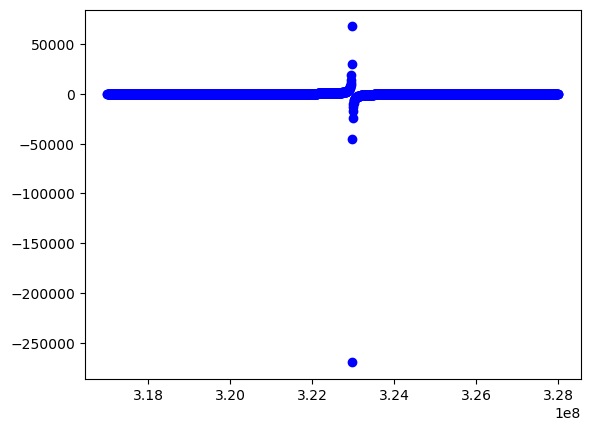

In [39]:
plt.scatter(C12_coefs, scattering_lengths, color = 'blue')

In [40]:
tol2 = 1e-9

as_of_interest = []
for i in range(len(C12_coefs)):
    #if -1e4 <= scattering_lengths[i] <= -0.1 or 0.1 <= scattering_lengths[i] <= 1e4:
    if 1 == 1:
        as_of_interest.append(scattering_lengths[i])
max_pos_as_oi = max(as_of_interest)
min_neg_as_oi = min(as_of_interest)
smallest_as_oi = min(np.absolute(as_of_interest))

print(f' largest positive as = {max_pos_as_oi}')
print(f' smallest negative as = {min_neg_as_oi}')
print(f' smallest magnitude as = {smallest_as_oi}')

for i in range(len(scattering_lengths)):
    if abs(scattering_lengths[i] - max_pos_as_oi) <= tol2:
        max_i = i
    if abs(scattering_lengths[i] - min_neg_as_oi) <= tol2:
        min_i = i
    if abs(scattering_lengths[i] - smallest_as_oi) <= tol2:
        small_i = i

print((max_i,min_i,small_i))
print(f' largest positive as = {scattering_lengths[max_i]}')
print(f' smallest negative as = {scattering_lengths[min_i]}')
print(f' smallest as = {scattering_lengths[small_i]}')

    
    
    

 largest positive as = 67930.85046869452
 smallest negative as = -269652.6174290021
 smallest magnitude as = 0.05957401838649711
(976, 977, 1655)
 largest positive as = 67930.85046869452
 smallest negative as = -269652.6174290021
 smallest as = 0.05957401838649711


# Start of arcTan(a/abar) vs FC for n = 0

# n = 0

In [43]:
key_state = 0
Psi_interesting = []
FC_Factors = [ [] for i in range(100) ]
for i in range(len(C12_coefs)):
    #if -1e4 <= scattering_lengths[i] <= -0.1 or 0.1 <= scattering_lengths[i] <= 1e4:
    if 1 == 1:
        #print(f'{scattering_lengths[i]}')
        if i == int(0.5*len(C12_coefs)):
            print('half way there!')
        if i == int(0.9*len(C12_coefs)):
            print('almost there!')

        VLJ_as = (C12_coefs[i]/(R_grid**12)) - (C6/(R_grid**6)) # a Lennard-Jones potential with a paticular scattering length
        psi = np.zeros(N_big-1)  # initializing psi(r) as array of zeros
        Psi_as = Numerov(Eo, N_big-1, VLJ_as, dr1, R_grid) # wave function Psi for a paticular scattering length
        if i == 1072:
            Big_FC_Numerov = Psi_as[r1_i + 1:r2_i - 1]
        for j in range(50):
            if j == key_state:   
                PHI_n = np.conjugate(Hvec[j])
                Integrand_n = PHI_n*Psi_as[r1_i + 1:r2_i - 1]

            Inner_Product_n = np.trapz(Integrand_n, r_grid)
            #if i == 1055:
               # print(Inner_Product_n)
            FC_Factors[j].append(Inner_Product_n)
            #if i == max_fc:
             #   Max_Numerov = Psi_as[r1_i + 1:r2_i - 1]
             #   Max_BS = PHI_n
            #if i == min_fc:
            #    Small_Numerov = Psi_as[r1_i + 1:r2_i - 1]
            #    Small_BS = PHI_n
            #if i == min_neg_fc:
            #    Neg_Integrand = Integrand_n
            #if i == min_i:
            #    small_as_int = Integrand_n
            #if i == max_i:
            #    large_as_int = Integrand_n


half way there!
almost there!


# n = 0 identify extreme FC factors

In [45]:
Ground_FC = FC_Factors[0]
print(max(Ground_FC))
for i in range(len(Ground_FC)):
    if abs(Ground_FC[i] - max(Ground_FC)) <= tol2:
        max_fc = i
    if abs(Ground_FC[i] - min(np.absolute(Ground_FC))) <= tol2:
        min_fc = i
    if abs(Ground_FC[i] - min(Ground_FC)) <= tol2:
        min_neg_fc = i

print((max_fc,min_fc,min_neg_fc))
print(Ground_FC[min_fc])
    
#print(Ground_FC)
#print(Ground_FC[-1])

4252.712976437158
(1066, 1263, 103)
1.5051059791805466


# n = 0 save extreme vals

In [47]:
Psi_interesting = []
FC_Factors = [ [] for i in range(100) ]
PEAK_PSIS = [] 
for i in range(len(C12_coefs)):
    #if -1e4 <= scattering_lengths[i] <= -0.1 or 0.1 <= scattering_lengths[i] <= 1e4:
    if 1 == 1:
        #print(f'{scattering_lengths[i]}')
        if i == int(0.5*len(C12_coefs)):
            print('half way there!')
        if i == int(0.9*len(C12_coefs)):
            print('almost there!')

        VLJ_as = (C12_coefs[i]/(R_grid**12)) - (C6/(R_grid**6)) # a Lennard-Jones potential with a paticular scattering length
        psi = np.zeros(N_big-1)  # initializing psi(r) as array of zeros
        Psi_as = Numerov(Eo, N_big-1, VLJ_as, dr1, R_grid) # wave function Psi for a paticular scattering length
        for j in range(50):
            if j == key_state:   
                PHI_n = np.conjugate(Hvec[j])
                Integrand_n = PHI_n*Psi_as[r1_i + 1:r2_i - 1]

            Inner_Product_n = np.trapz(Integrand_n, r_grid)
            #if i == 1055:
               # print(Inner_Product_n)
            FC_Factors[j].append(Inner_Product_n)
            max_is = np.arange(int(max_fc - 5), int(max_fc + 6), 1)
            if i == max_fc:
                Max_Numerov = Psi_as[r1_i + 1:r2_i - 1]
                Max_BS = PHI_n
            if i == np.any(max_is):
                PEAK_PSIS.append((i,Psi_as[r1_i + 1:r2_i - 1]))
            if i == min_fc:
                Small_Numerov = Psi_as[r1_i + 1:r2_i - 1]
                Small_BS = PHI_n
            if i == min_neg_fc:
                Neg_Integrand = Integrand_n
            if i == min_i:
                small_as_int = Integrand_n
            if i == max_i:
                large_as_int = Integrand_n

half way there!
almost there!


# Plot FC factor sqrt

1800
 abar = 78.6726486794721
1800
usable a length = 1800


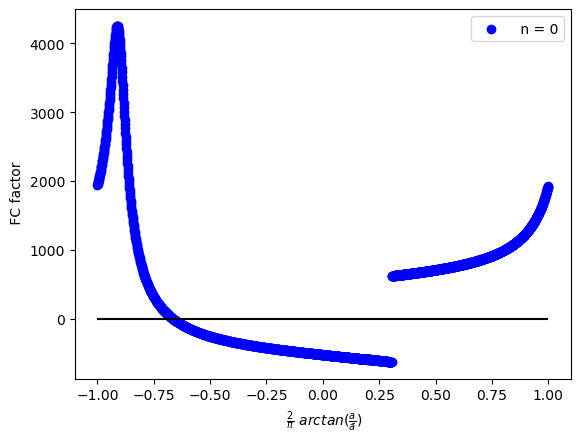

In [49]:
plt.hlines(0, -1, 1, color = 'black')
plt.vlines(0, -1, 1, color = 'black')
print(len(FC_Factors[0]))
a_bar = 0.4780*((2*mu*C6)**0.25)
print(f' abar = {a_bar}')
scaled_a = []
#print(len(scattering_lengths))
for i in range(len(scattering_lengths)):
    #if -1e4 <= scattering_lengths[i] <= -0.1 or 0.1 <= scattering_lengths[i] <= 1e4:
    if 1 == 1:
        scaled_a.append(scattering_lengths[i]*(1/a_bar))
tan_a = (2/np.pi)*np.arctan(scaled_a)
print(len(tan_a))
print(f'usable a length = {len(scaled_a)}')
plt.scatter(tan_a, Ground_FC, color = 'blue', label = f' n = {0}') 

plt.xlim(-1.1,1.1)
#plt.ylim(-3,3)
plt.ylabel(f' FC factor')
plt.xlabel(' $ \\frac{2}{ \\pi } $ $ arctan( \\frac{a}{ \\bar{a} }) $')
plt.legend()

# n = 0 FC Factor vs a

1800
 abar = 78.6726486794721
1800
usable a length = 1800


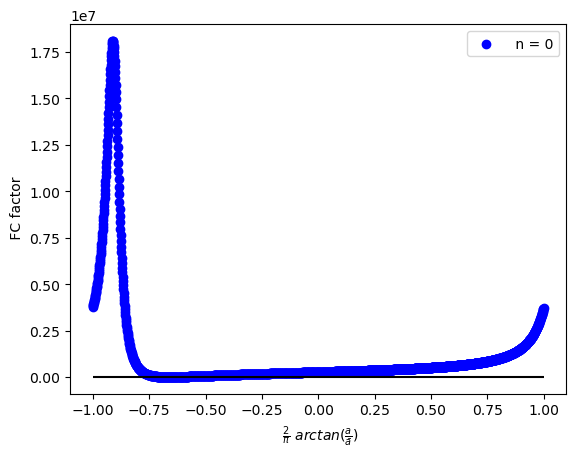

In [51]:
plt.hlines(0, -1, 1, color = 'black')
plt.vlines(0, -1, 1, color = 'black')
print(len(FC_Factors[0]))
a_bar = 0.4780*((2*mu*C6)**0.25)
print(f' abar = {a_bar}')
scaled_a = []
#print(len(scattering_lengths))
for i in range(len(scattering_lengths)):
    #if -1e4 <= scattering_lengths[i] <= -0.1 or 0.1 <= scattering_lengths[i] <= 1e4:
    if 1 == 1:
        scaled_a.append(scattering_lengths[i]*(1/a_bar))
#big_list = np.linspace(int(-1e100),int(1e100), int(15e6))
#tan_a = (2/np.pi)*np.arctan(big_list)
tan_a = (2/np.pi)*np.arctan(scaled_a)
print(len(tan_a))
print(f'usable a length = {len(scaled_a)}')
plt.scatter(tan_a, np.absolute(Ground_FC)**2, color = 'blue', label = ' n = 0') 

#for i in range(len(Ground_FC)):
    #if i == max_fc:
    #    plt.vlines(tan_a[i], 0, Ground_FC[i],  color = 'orange')
    #if i == max_i:
    #    plt.vlines(tan_a[i], 0, Ground_FC[i],  color = 'crimson')
    #if i == min_i:
    #    plt.vlines(tan_a[i], 0, Ground_FC[i],  color = 'lime')
    #if i == min_fc:
    #    plt.vlines(tan_a[i], -1e2, 1e2,  color = 'darksalmon')
    #if i == min_neg_fc:
    #    plt.vlines(tan_a[i], Ground_FC[i], 0, color = 'deeppink')
        

#plt.xlim(-1.1,1.1)
#plt.ylim(-3,1e3)
plt.ylabel(f' FC factor')
plt.xlabel(' $ \\frac{2}{ \\pi } $ $ arctan( \\frac{a}{ \\bar{a} }) $')
plt.legend()


## NOTE:
### Largest positive and smallest negative scattering lengths have similar FC factors
### Look at inner product for largest and 0 FC factors

# Largest FC factor

(40.0, 100.0)

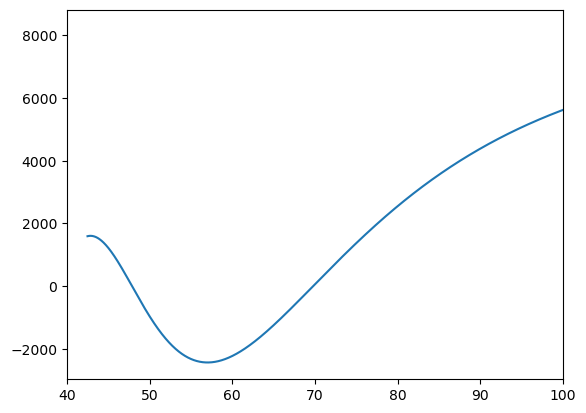

In [54]:
plt.plot(r_grid, Big_FC_Numerov)
plt.xlim(40,100)

Text(0, 0.5, 'FC Factor')

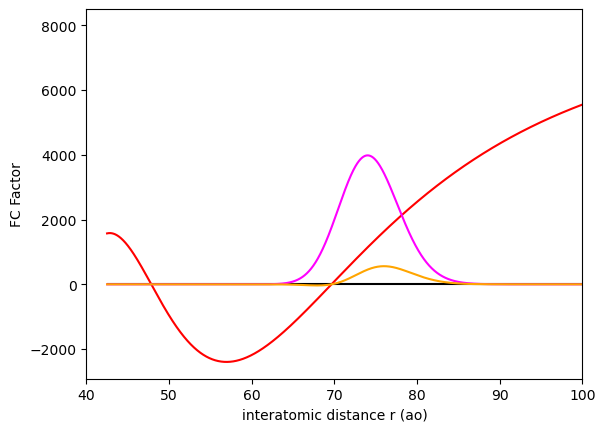

In [55]:
plt.hlines(0, r1,r2, color = 'black')
plt.plot(r_grid, Max_Numerov, color = 'red')
plt.plot(r_grid, 10000*Max_BS, color = 'fuchsia')
plt.plot(r_grid, Max_Numerov*Max_BS, color = 'orange')
#print(np.trapz(Max_Integrand,r_grid))
plt.xlim(40,100)
plt.xlabel('interatomic distance r (ao)')
plt.ylabel('FC Factor')

# FC factor $\approx$ 0

1.5051059791805466


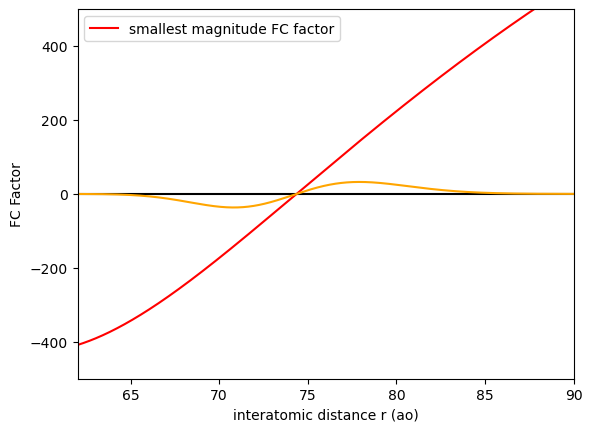

In [57]:
plt.hlines(0, r1,r2, color = 'black')
plt.plot(r_grid, Small_Numerov, color = 'red', label = 'smallest magnitude FC factor')
#plt.plot(r_grid, 1000*Small_BS, color = 'fuchsia', label = 'smallest magnitude FC factor')
plt.plot(r_grid, np.conjugate(Small_BS)*Small_Numerov, color = 'orange')
print(np.trapz(Small_Numerov*Small_BS,r_grid))
plt.xlim(62,90)
plt.ylim(-500,500)
plt.xlabel('interatomic distance r (ao)')
plt.ylabel('FC Factor')
plt.legend()

# FC factor large negative

-624.6296653553362


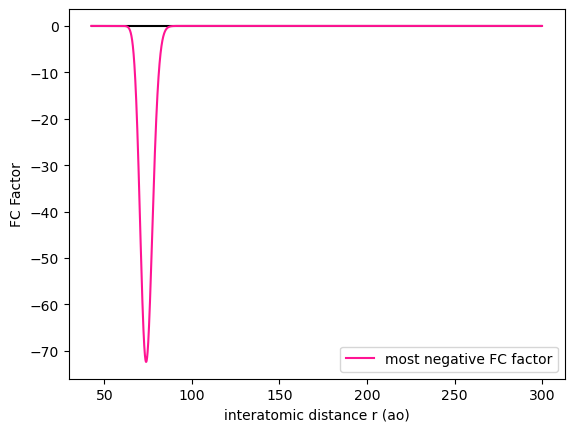

In [59]:
plt.hlines(0, r1,r2, color = 'black')
plt.plot(r_grid, Neg_Integrand, color = 'deeppink', label = 'most negative FC factor')
print(np.trapz(Neg_Integrand,r_grid))
plt.xlabel('interatomic distance r (ao)')
plt.ylabel('FC Factor')
plt.legend()

# FC factor for largest positive/negative scattering lengths

 largest scattering length FC = 1930.741526741172
 smallest scattering length FC = 1942.811142409309


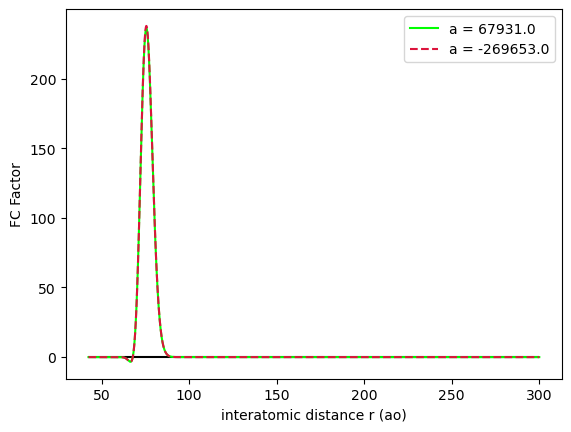

In [61]:
plt.hlines(0, r1,r2, color = 'black')
plt.plot(r_grid, large_as_int, color = 'lime', label = f'a = {round(scattering_lengths[max_i],0)}')
plt.plot(r_grid, small_as_int, color = 'crimson', linestyle = 'dashed', label = f'a = {round(scattering_lengths[min_i],0)}')

print(f' largest scattering length FC = {np.trapz(large_as_int,r_grid)}')
print(f' smallest scattering length FC = {np.trapz(small_as_int,r_grid)}')
plt.xlabel('interatomic distance r (ao)')
plt.ylabel('FC Factor')
plt.legend()

# End of arcTan(a/abar) vs FC for n = 0

# Start of arcTan(a/abar) vs FC for n = 1

In [64]:
Psi_interesting = []
FC_Factors = [ [] for i in range(100) ]
for i in range(len(C12_coefs)):
    #if -1e4 <= scattering_lengths[i] <= -0.1 or 0.1 <= scattering_lengths[i] <= 1e4:
    if 1 == 1:
        #print(f'{scattering_lengths[i]}')
        if i == int(0.5*len(C12_coefs)):
            print('half way there!')
        if i == int(0.9*len(C12_coefs)):
            print('almost there!')
    VLJ_as = (C12_coefs[i]/(R_grid**12)) - (C6/(R_grid**6)) # a Lennard-Jones potential with a paticular scattering length
    psi = np.zeros(N_big-1)  # initializing psi(r) as array of zeros
    Psi_as = Numerov(Eo, N_big-1, VLJ_as, dr1, R_grid) # wave function Psi for a paticular scattering length
    for j in range(50):    
        if j == 1:
            PHI_n = np.conjugate(Hvec[j])
            Integrand_n = PHI_n*Psi_as[r1_i + 1:r2_i - 1]

            Inner_Product_n = np.trapz(Integrand_n, r_grid)
            #if i == 1055:
               # print(Inner_Product_n)
            FC_Factors[j].append(Inner_Product_n)
            if i == 0:
                outlier_Integrand = Integrand_n
                #print(np.trapz(outlier_Integrand, r_grid))
            if i == 1:
                normal_Integrand = Integrand_n

half way there!
almost there!


 outlier FC = 25.47025301323174
 next FC = 24.891374065056713


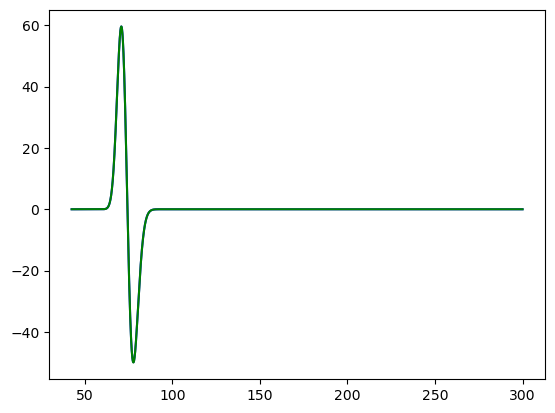

In [65]:
plt.plot(r_grid, outlier_Integrand, color = 'blue')
plt.plot(r_grid, normal_Integrand, color = 'green')

print(f' outlier FC = {np.trapz(outlier_Integrand, r_grid)}')
print(f' next FC = {np.trapz(normal_Integrand, r_grid)}')

In [66]:
Excited_FC = FC_Factors[1]
print(max(Excited_FC))
for i in range(len(Excited_FC)):
    if abs(Excited_FC[i] - max(Excited_FC)) <= tol2:
        max_fc = i
    if abs(Excited_FC[i] - min(np.absolute(Excited_FC))) <= tol2:
        min_fc = i

print((max_fc,min_fc))
print(Excited_FC[min_fc])
    
#print(Ground_FC)
#print(Ground_FC[-1])

5140.809746274382
(1071, 45)
0.09575852293701961


0
 abar = 78.6726486794721
1800
usable a length = 1800


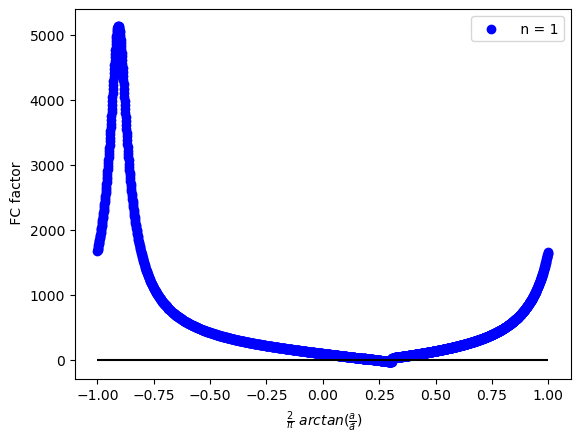

In [67]:
plt.hlines(0, -1, 1, color = 'black')
plt.vlines(0, -1, 1, color = 'black')
print(len(FC_Factors[0]))
a_bar = 0.4780*((2*mu*C6)**0.25)
print(f' abar = {a_bar}')
scaled_a = []
#print(len(scattering_lengths))
for i in range(len(scattering_lengths)):
    #if -1e4 <= scattering_lengths[i] <= -0.1 or 0.1 <= scattering_lengths[i] <= 1e4:
    if 1 == 1:
        scaled_a.append(scattering_lengths[i]*(1/a_bar))
#big_list = np.linspace(int(-1e100),int(1e100), int(15e6))
#tan_a = (2/np.pi)*np.arctan(big_list)
tan_a = (2/np.pi)*np.arctan(scaled_a)
print(len(tan_a))
print(f'usable a length = {len(scaled_a)}')
plt.scatter(tan_a, Excited_FC, color = 'blue', label = f' n = {1}') 

#for i in range(len(Ground_FC)):
#    if i == max_fc:
#        plt.vlines(tan_a[i], 0, Excited_FC[i],  color = 'orange')
#    if i == max_i:
#        plt.vlines(tan_a[i], 0, Excited_FC[i],  color = 'crimson')
#    if i == min_i:
#        plt.vlines(tan_a[i], 0, Excited_FC[i],  color = 'lime')
#    if i == min_fc:
#        plt.vlines(tan_a[i], -1e2, 1e2,  color = 'darksalmon')
plt.xlim(-1.1,1.1)
#plt.ylim(-3,3)
plt.ylabel(f' FC factor')
plt.xlabel(' $ \\frac{2}{ \\pi } $ $ arctan( \\frac{a}{ \\bar{a} }) $')
plt.legend()

In [68]:
for i in range(-1,len(Excited_FC)):
    if abs(Excited_FC[i] - Excited_FC[i-1]) > 750:
        print((i-1,i,i+1))
        break
#plt.scatter(tan_a, Excited_FC, color = 'blue', label = f' n = {0}') 

for i in range(-1,len(Excited_FC)):
    if i <= 1:
        print(Excited_FC[i])


12.415327081549767
25.47025301323174
24.891374065056713


# End of n = 1

# Comparison of n = 0,1,2,3,4,5,6,7,8

In [71]:
comparison_n = 51
Psi_interesting = []
FC_Factors = [ [] for i in range(comparison_n) ]
for i in range(len(C12_coefs)):
    #if -1e4 <= scattering_lengths[i] <= -0.1 or 0.1 <= scattering_lengths[i] <= 1e4:
    if 1 == 1:
        #print(f'{scattering_lengths[i]}')
        if i == int(0.5*len(C12_coefs)):
            print('half way there!')
        if i == int(0.9*len(C12_coefs)):
            print('almost there!')

        VLJ_as = (C12_coefs[i]/(R_grid**12)) - (C6/(R_grid**6)) # a Lennard-Jones potential with a paticular scattering length
        psi = np.zeros(N_big-1)  # initializing psi(r) as array of zeros
        Psi_as = Numerov(Eo, N_big-1, VLJ_as, dr1, R_grid) # wave function Psi for a paticular scattering length
        for j in range(comparison_n):
            PHI_n = np.conjugate(Hvec[j])
            Integrand_n = PHI_n*Psi_as[r1_i + 1:r2_i - 1]

            Inner_Product_n = np.trapz(Integrand_n, r_grid)
            #if i == 1055:
               # print(Inner_Product_n)
            FC_Factors[j].append(abs(Inner_Product_n)**2)

half way there!
almost there!


1800
 abar = 78.6726486794721
1800
usable a length = 1800


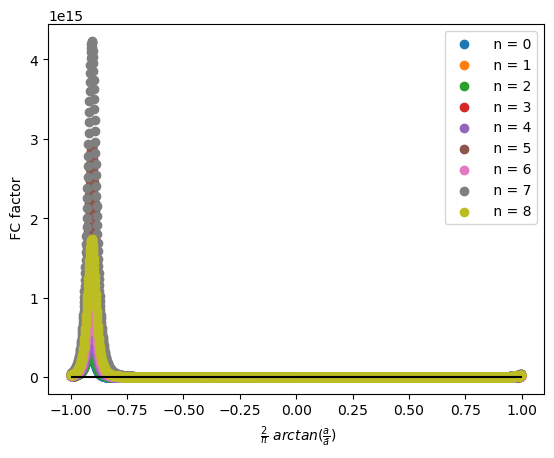

In [80]:
plt.hlines(0, -1, 1, color = 'black')
plt.vlines(0, -1, 1, color = 'black')
print(len(FC_Factors[0]))
a_bar = 0.4780*((2*mu*C6)**0.25)
print(f' abar = {a_bar}')
scaled_a = []
#print(len(scattering_lengths))
for i in range(len(scattering_lengths)):
    #if -1e4 <= scattering_lengths[i] <= -0.1 or 0.1 <= scattering_lengths[i] <= 1e4:
    if 1 == 1:
        scaled_a.append(scattering_lengths[i]*(1/a_bar))
#big_list = np.linspace(int(-1e100),int(1e100), int(15e6))
#tan_a = (2/np.pi)*np.arctan(big_list)
tan_a = (2/np.pi)*np.arctan(scaled_a)
print(len(tan_a))
print(f'usable a length = {len(scaled_a)}')
for j in range(comparison_n):
    #if j <= 1:
    if 0<= j <= 8:
        plt.scatter(tan_a, np.absolute(FC_Factors[j])**2, label = f' n = {j}') 
    #if j == 45:
    #    plt.scatter(tan_a, np.absolute(FC_Factors[j])**2, label = f' n = {j}')

#for i in range(len(Ground_FC)):
#    if i == max_fc:
#        plt.vlines(tan_a[i], 0, Excited_FC[i],  color = 'orange')
#    if i == max_i:
#        plt.vlines(tan_a[i], 0, Excited_FC[i],  color = 'crimson')
#    if i == min_i:
#        plt.vlines(tan_a[i], 0, Excited_FC[i],  color = 'lime')
#    if i == min_fc:
#        plt.vlines(tan_a[i], -1e2, 1e2,  color = 'darksalmon')
plt.xlim(-1.1,1.1)
#plt.ylim(-3,3)
plt.ylabel(f' FC factor')
plt.xlabel(' $ \\frac{2}{ \\pi } $ $ arctan( \\frac{a}{ \\bar{a} }) $')
plt.legend()

# End of comparison between n levels

# $\sigma_{PA } = \frac{\gamma \Gamma}{(E-\Delta ')^2 + [\frac{\gamma + \Gamma}{2}]^2}$
# $\sigma_{PA res n} = \frac{4 \gamma \Gamma_n}{{(\gamma + \Gamma_n})^2}$
## $\Gamma_n = 2 \pi U^2 |\braket{\varphi_{n}|\psi_{s}}|^2 $
## $ U^2 = \frac{\Gamma_0}{2 \pi |\braket{\varphi_{0}|\psi_{s}}|^2}$ with $\Gamma_0 = 10$GHz
## $\gamma = \frac{1}{\tau} = 0.1$GHz, $\tau = 10^{-8}s$
## $\Delta ' = \Delta  - \braket{\varphi_{b}|UGU|\varphi_{b}} = E1 - \hbar \omega$, $E1 = 0$ since excited potential goes to 0, or has binding energy 0

Text(0.5, 1.0, 'Bound State level vs Scattering Length corresponding to maximum FC Factor')

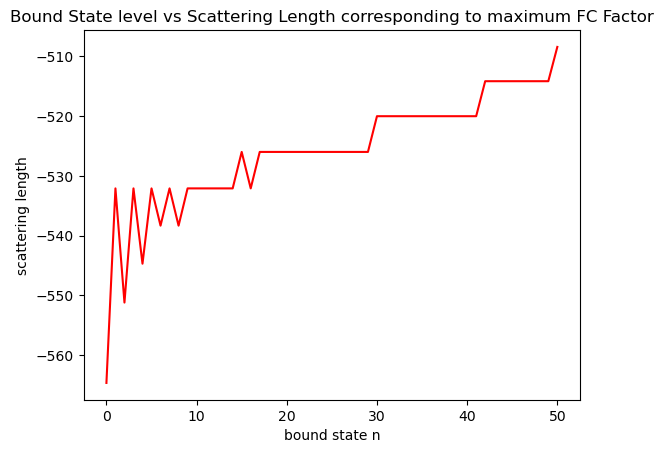

In [117]:
small_fcs = []
count = 0
tol3 = 1e-12
Max_FC_indexes = []
Min_FC_indexes = []
for i in range(comparison_n):
    maxii = FC_Factors[i].index(max(FC_Factors[i]))
    minii = FC_Factors[i].index(min(np.absolute(FC_Factors[i])))
    Max_FC_indexes.append(maxii)
    Min_FC_indexes.append(minii)
#print(Max_FC_indexes)
#print(Min_FC_indexes)
Max_sls = []
Min_sls = []
for i in range(comparison_n):
    Max_sls.append(scattering_lengths[Max_FC_indexes[i]])
    Min_sls.append(scattering_lengths[Min_FC_indexes[i]])
plt.plot(Bound_States, Max_sls, color = 'red')
plt.xlabel('bound state n')
plt.ylabel('scattering length')
plt.title('Bound State level vs Scattering Length corresponding to maximum FC Factor')

Text(0.5, 1.0, 'Bound State level vs Scattering Length corresponding to minimum FC Factor')

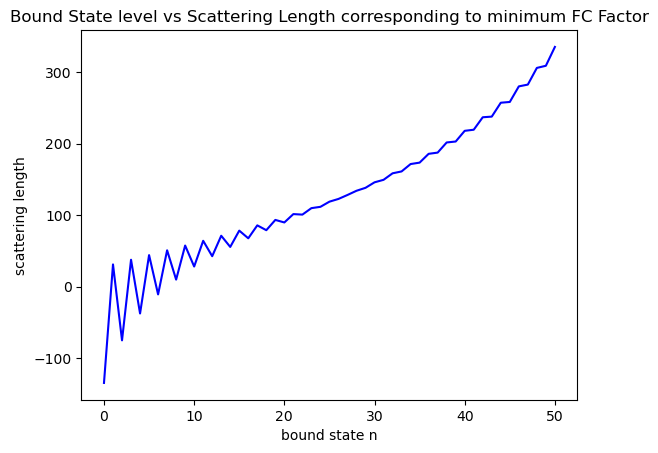

In [119]:
plt.plot(Bound_States, Min_sls, color = 'blue')
plt.xlabel('bound state n')
plt.ylabel('scattering length')
plt.title('Bound State level vs Scattering Length corresponding to minimum FC Factor')

In [121]:
Max_Numerovs = []
Min_Numerovs = []

for i in range(len(Max_FC_indexes)):
    VLJ_as = (C12_coefs[Max_FC_indexes[i]]/(R_grid**12)) - (C6/(R_grid**6)) # a Lennard-Jones potential with a paticular scattering length
    psi = np.zeros(N_big-1)  # initializing psi(r) as array of zeros
    Psi_as = Numerov(Eo, N_big-1, VLJ_as, dr1, R_grid) # wave function Psi for a paticular scattering length
    Max_Numerovs.append(Psi_as[r1_i + 1:r2_i - 1])
for i in range(len(Min_FC_indexes)):
    VLJ_as = (C12_coefs[Min_FC_indexes[i]]/(R_grid**12)) - (C6/(R_grid**6)) # a Lennard-Jones potential with a paticular scattering length
    psi = np.zeros(N_big-1)  # initializing psi(r) as array of zeros
    Psi_as = Numerov(Eo, N_big-1, VLJ_as, dr1, R_grid) # wave function Psi for a paticular scattering length
    Min_Numerovs.append(Psi_as[r1_i + 1:r2_i - 1])


In [123]:
for i in range(len(FC_Factors)):
    minvalu = min(np.absolute(FC_Factors[i]))
   # print(minvalu)

#for i in range(len(Min_FC_indexes)):
    #print(FC_Factors[i][Min_FC_indexes[i]])

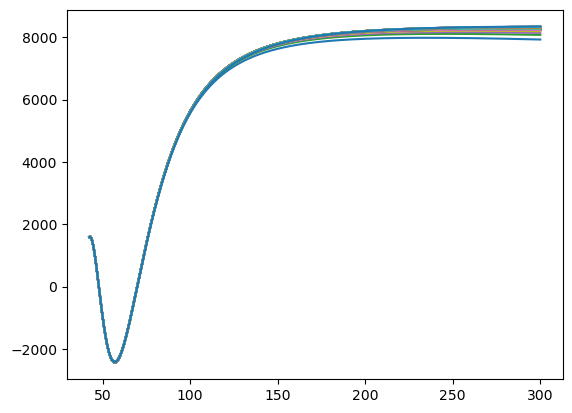

In [125]:
for i in range(comparison_n):
    plt.plot(r_grid, Max_Numerovs[i])

33589839.726914436


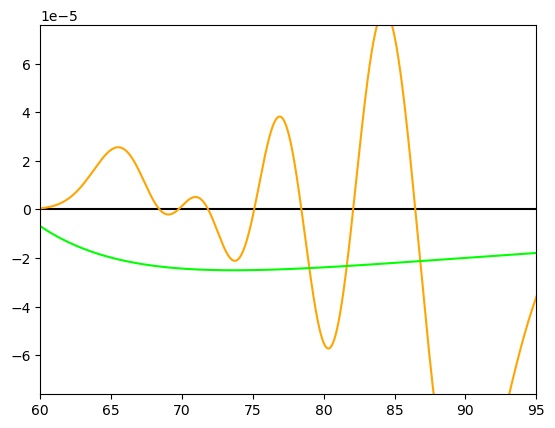

In [127]:
plt.hlines(0,0,max(r_grid), color = 'black')
for i in range(comparison_n):
    if i == 6:
        #plt.plot(r_grid, (1/(60*1e6))*Max_Numerovs[i], color = 'blue')
        #plt.plot(r_grid, 1e-5*np.conjugate(Hvec[i]), color = 'fuchsia') 
        plt.plot(r_grid, 1e-7*np.conjugate(Hvec[i])*Max_Numerovs[i], color = 'orange')
        print(abs(np.trapz(np.conjugate(Hvec[i])*Max_Numerovs[i], r_grid))**2)

plt.xlim(60,95)
plt.ylim(-76e-6,76e-6)
#plt.ylim(

VExcited = (C6p)/(r_grid**6) - (C3)/(r_grid**3)
plt.plot(r_grid, VExcited, color = 'lime')
#plt.plot(r_grid, 1e-5*np.conjugate(Hvec[0]), color = 'fuchsia')

0.009169694715079712


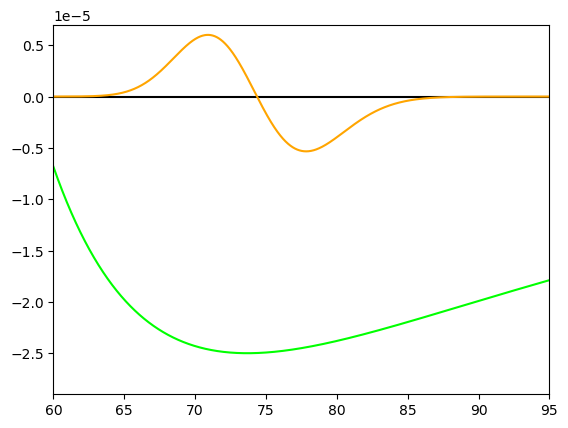

In [129]:
plt.hlines(0,0,max(r_grid), color = 'black')
for i in range(len(Min_FC_indexes)):
    if i == 1:
        #plt.plot(r_grid, (1/(60*1e6))*Min_Numerovs[i], color = 'blue')
        #plt.plot(r_grid, 1e-5*np.conjugate(Hvec[i]), color = 'fuchsia') 
        plt.plot(r_grid, 1e-7*np.conjugate(Hvec[i])*Min_Numerovs[i], color = 'orange')
        print(abs(np.trapz(np.conjugate(Hvec[i])*Min_Numerovs[i], r_grid))**2)

plt.xlim(60,95)
plt.ylim(-2.9e-5,7e-6)
#plt.ylim(

VExcited = (C6p)/(r_grid**6) - (C3)/(r_grid**3)
plt.plot(r_grid, VExcited, color = 'lime')
#plt.plot(r_grid, 1e-5*np.conjugate(Hvec[0]), color = 'fuchsia')

In [337]:
print(f'max fc factor = {max_fc}')
print(f'min fc factor = {min_fc}')
print(f'most negative fc factor = {min_neg_fc}')
print(f'max a index = {max_i}')
print(f'min a index = {min_i}')
VLJ_maxn0 = (C12_coefs[1070]/(R_grid**12)) - (C6/(R_grid**6))
Psi_S = Numerov(Eo, N_big - 1, VLJ_maxn0, dr1, R_grid)
#plt.plot(r_grid, np.conjugate(Hvec[0])*Psi_S[r1_i + 1:r2_i - 1])
tau = 10e-8 
gamma = 1/tau
FC_0 = np.abs(np.trapz(np.conjugate(Hvec[0])*Psi_S[r1_i + 1:r2_i - 1], r_grid))**2
U_sq = (100*gamma)/(2*np.pi*FC_0)
print(f'U_sq = {U_sq}')
Gamma = 2*np.pi*U_sq*FC_0
print(f'gamma/Gamma = {gamma/Gamma}')
Sigma_0 = (gamma*Gamma)/(((gamma + Gamma)/2)**2)
print(f'Sigma(n=0) = {Sigma_0}')
#print(f' Taylor approx sigma = {Sigma_Taylor}')

max fc factor = 1071
min fc factor = 45
most negative fc factor = 103
max a index = 976
min a index = 977
U_sq = 8.921991444936374
gamma/Gamma = 0.01
Sigma(n=0) = 0.039211841976276834


In [607]:
def Sigma_PA_res(n, index): # finds the resonant photoassociation cross section, returns cross section and Gamma
    sigma_list = []
    Gamma_list = []
    Sigma_small = []
    VLJ_PA = (C12_coefs[index]/(R_grid**12)) - (C6/(R_grid**6))
    Psi_S = Numerov(Eo, N_big - 1, VLJ_PA, dr1, R_grid)
    for i in range(n):
        FC_n = np.abs(np.trapz(np.conjugate(Hvec[i])*Psi_S[r1_i + 1:r2_i - 1], r_grid))**2
        Gamma_n = Gamma = 2*np.pi*U_sq*FC_n
        Gamma_list.append(Gamma_n)
        sigma_n = (4*gamma*Gamma_n)/((gamma + Gamma_n)**2)
        sigma_list.append(sigma_n)
        smegma_small = (4*Gamma)/(gamma)
    return((sigma_list,Gamma_list))

# $\sigma_{PA}$ vs n for $a_s$ s.t. FC is at a maximum

26223761.88554575
Sigma_4 = 0.02684323340192736
[-564.64, -532.08, -551.19, -532.08, -544.68, -532.08, -538.32, -532.08, -538.32, -532.08, -532.08, -532.08, -532.08, -532.08, -532.08, -525.98, -532.08, -525.98, -525.98, -525.98, -525.98, -525.98, -525.98, -525.98, -525.98, -525.98, -525.98, -525.98, -525.98, -525.98, -520.0, -520.0, -520.0, -520.0, -520.0, -520.0, -520.0, -520.0, -520.0, -520.0, -520.0, -520.0, -514.14, -514.14, -514.14, -514.14, -514.14, -514.14, -514.14, -514.14, -508.4]


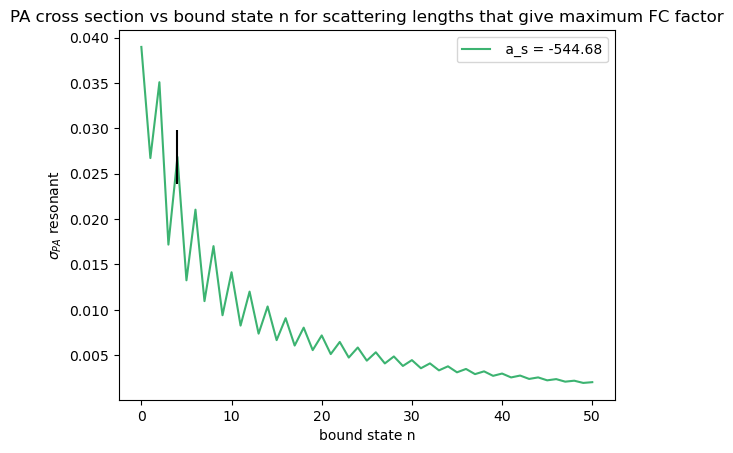

In [615]:
for i in range(len(Max_FC_indexes)):
    if i == 4:

        SigmaPA_largeFC = Sigma_PA_res(comparison_n,Max_FC_indexes[i])[0]
        print(FC_Factors[i][Max_FC_indexes[i]])
        Gamma_largeFC = Sigma_PA_res(comparison_n,Max_FC_indexes[i])[1]

        plt.plot(Bound_States, SigmaPA_largeFC, color = 'mediumseagreen', label = f' a_s = {round(Max_sls[i],2)}')
        plt.vlines(Bound_States[i],SigmaPA_largeFC[i] - 0.003,SigmaPA_largeFC[i] + 0.003,color = 'black')
        #plt.plot(Bound_States, Gamma_largeFC)
        print(f'Sigma_{i} = {SigmaPA_largeFC[i]}')
    
plt.xlabel('bound state n')
plt.ylabel('$\\sigma_{PA}$ resonant')
plt.legend()  
plt.title('PA cross section vs bound state n for scattering lengths that give maximum FC factor')

rounded_Max_sls = []
for i in range(len(Max_sls)):
    rounded_Max_sls.append(round(Max_sls[i],2))
print(rounded_Max_sls)

# $\Gamma_n$ vs n for $a_s$ s.t. FC is at a maximum

FC Factor = 26223761.88554575
Gamma_4 = 1470065425.8774457


Text(0.5, 1.0, 'Gamma_n vs bound state n for scattering lengths that give maximum FC factor')

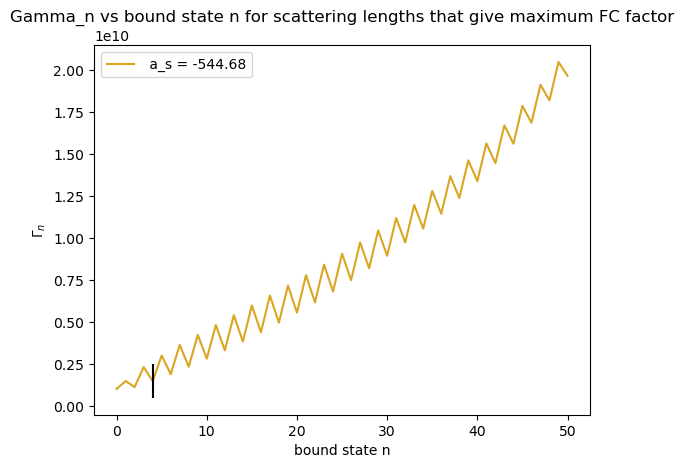

In [618]:
for i in range(len(Max_FC_indexes)):
    if i == 4:
        
        print(f'FC Factor = {FC_Factors[i][Max_FC_indexes[i]]}')
        Gamma_largeFC = Sigma_PA_res(comparison_n,Max_FC_indexes[i])[1]

        plt.plot(Bound_States, Gamma_largeFC, color = 'goldenrod', label = f' a_s = {round(Max_sls[i],2)}')
        plt.vlines(Bound_States[i],Gamma_largeFC[i] - 0.1e10,Gamma_largeFC[i] + 0.1e10, color = 'black')
        print(f'Gamma_{i} = {Gamma_largeFC[i]}')
    
plt.xlabel('bound state n')
plt.ylabel('$\\Gamma_{n}$')
plt.legend()  
plt.title('Gamma_n vs bound state n for scattering lengths that give maximum FC factor')

# $\sigma_{PA}$ vs n for $a_s$ s.t. FC $\approx$ 0

FC Factor = 0.022779173498000238
Sigma_3 = 5.107866214359889e-07
[-134.86, 30.97, -75.28, 37.5, -37.65, 44.01, -10.99, 50.73, 9.72, 57.38, 28.02, 64.03, 42.47, 71.08, 55.44, 78.26, 67.52, 85.63, 78.86, 93.24, 89.7, 101.4, 100.67, 109.72, 111.57, 118.79, 122.6, 128.15, 134.03, 138.17, 145.86, 149.35, 158.46, 161.1, 171.42, 173.42, 185.73, 187.44, 201.63, 202.96, 217.92, 219.46, 236.9, 237.8, 257.25, 258.3, 280.11, 282.62, 305.95, 308.95, 335.33]


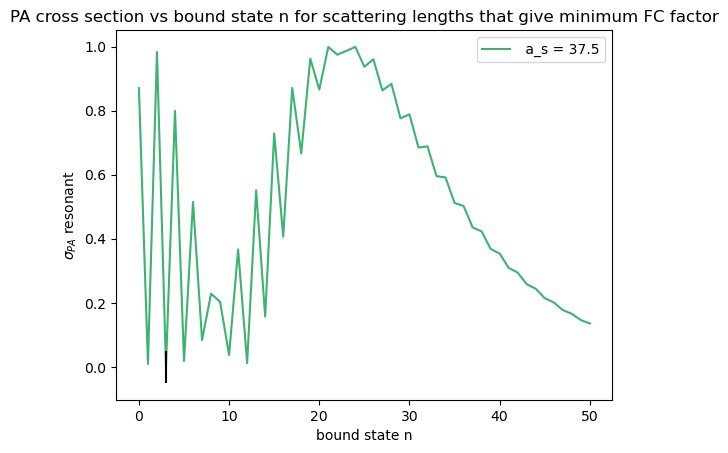

In [620]:
for i in range(len(Min_FC_indexes)):
    if i == 3:
        SigmaPA_smallFC = Sigma_PA_res(comparison_n,Min_FC_indexes[i])[0]
        print(f'FC Factor = {FC_Factors[i][Min_FC_indexes[i]]}')
        Gamma_smallFC = Sigma_PA_res(comparison_n,Min_FC_indexes[i])[1]

        plt.plot(Bound_States, SigmaPA_smallFC, color = 'mediumseagreen', label = f' a_s = {round(Min_sls[i],2)}')
        plt.vlines(Bound_States[i],-0.05,0.05,color = 'black')
        print(f'Sigma_{i} = {SigmaPA_smallFC[i]}')
        #plt.scatter(Min_sls, SigmaPA_smallFC)
        #plt.plot(Bound_States, Gamma_smallFC)
        #print(f'Gamma_{i} = {Gamma_smallFC[i]}')

plt.xlabel('bound state n')
plt.ylabel('$\\sigma_{PA}$ resonant')
plt.legend()  
plt.title('PA cross section vs bound state n for scattering lengths that give minimum FC factor')
    
    
    
rounded_Min_sls = []
for i in range(len(Min_sls)):
    rounded_Min_sls.append(round(Min_sls[i],2))
print(rounded_Min_sls)

# $\Gamma_n$ vs n for $a_s$ s.t. FC $\approx$ 0

FC Factor = 0.022779173498000238
Gamma_3 = 1.276966879718792


Text(0.5, 1.0, 'Gamma_n vs bound state n for scattering lengths that give minimum FC factor')

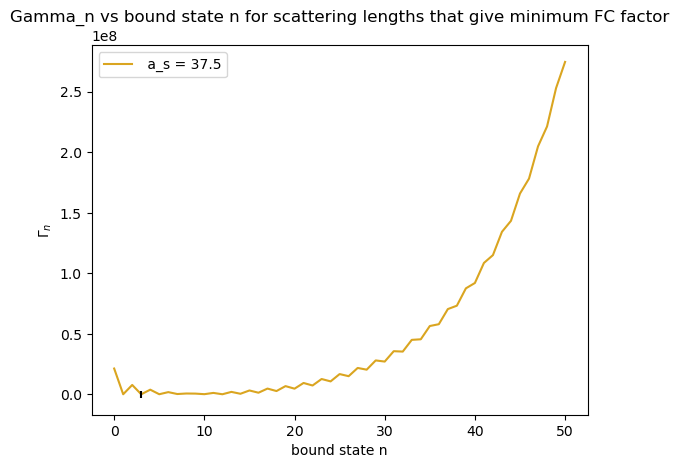

In [623]:
for i in range(len(Min_FC_indexes)):
    if i == 3:
        
        print(f'FC Factor = {FC_Factors[i][Min_FC_indexes[i]]}')
        Gamma_minFC = Sigma_PA_res(comparison_n,Min_FC_indexes[i])[1]

        plt.plot(Bound_States, Gamma_minFC, color = 'goldenrod', label = f' a_s = {round(Min_sls[i],2)}')
        plt.vlines(Bound_States[i],Gamma_minFC[i] - 0.3e7,Gamma_minFC[i] + 0.3e7, color = 'black')
        print(f'Gamma_{i} = {Gamma_minFC[i]}')
    
plt.xlabel('bound state n')
plt.ylabel('$\\Gamma_{n}$')
plt.legend()  
plt.title('Gamma_n vs bound state n for scattering lengths that give minimum FC factor')

# $\sigma_{PA}$ vs n for random $a_s$

[1069, 933]


Text(0.5, 1.0, 'PA cross section vs bound state n for random scattering lengths')

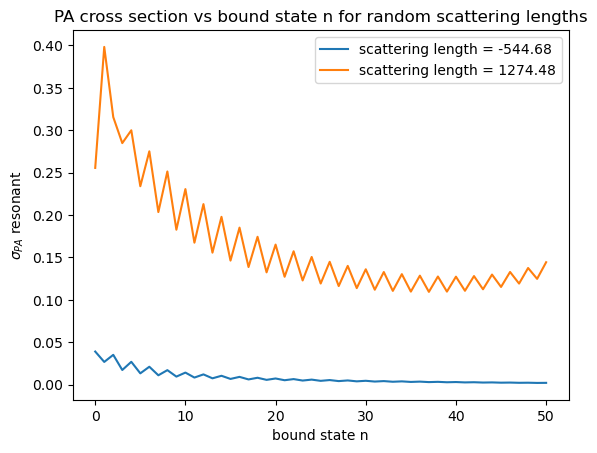

In [639]:
import random
random_C12 = [random.randint(0,len(C12_coefs)),random.randint(0,len(C12_coefs))]
print(random_C12)
for i in range(len(random_C12)):
    #if i <= 3:

    SigmaPA_rand = Sigma_PA_res(comparison_n,random_C12[i])[0]
    Gamma_rand = Sigma_PA_res(comparison_n,random_C12[i])[1]

    plt.plot(Bound_States, SigmaPA_rand, label = f'scattering length = {round(scattering_lengths[random_C12[i]],2)}')
    #plt.plot(Bound_States, Gamma_rand, label = f'scattering length = {round(scattering_lengths[random_C12[i]],3)}')
    
plt.xlabel('bound state n')
plt.ylabel('$\\sigma_{PA}$ resonant')
plt.legend()
plt.title('PA cross section vs bound state n for random scattering lengths')

# End of $\sigma_{PA}$ vs n

In [ ]:
#plt.hlines(0, min(r_grid), max(r_grid), color = 'black')
#plt.plot(r_grid, Psi_interesting, color = 'red', label = 'scattering state')
#for i in range(len(Heig[Heig<0])):
#    if i == 0:
#        PHI_B = np.conjugate(Hvec[i])
#        plt.plot(rppp, PHI_B, color = 'fuchsia', label = f'bound state n = {i+1}')

#plt.xlabel('interatomic distance r $(a_o)$')
#plt.ylabel('wave function')
#plt.legend()

#|plt.xlim(min(r_grid),110)

In [ ]:
plt.hlines(0, min(r_grid), max(r_grid), color = 'black')
#plt.plot(rppp, Psi_interesting, color = 'red', label = 'scattering state')
for i in range(len(Heig[Heig<0])):
    if i == 0:
        PHI_B = np.conjugate(Hvec[i])
        plt.plot(r_grid, PHI_B*Psi_interesting, color = 'darkorange', label = f' n = {i+1}')

plt.xlabel('interatomic distance r $(a_o)$')
plt.ylabel('$ \\varphi^*_{b} \\psi_{s}$')
plt.legend()

plt.xlim(min(r_grid),110)

In [ ]:
scattering_lengths = [113.8516551094902, 5.746321736477064, 20.606160274287053, 247.79307096472178, 4026.3286646216734, 351.4251021304227, 81.99422257251294, 297.3309524501701, 4232.476206466469, -179.45201030003605, 729.0426690692904, 138.41981172299035, 34.4601787324823, 251.46816473119452, 22.434179895789313, 120.95363253404201, 474.40137082945125, -70.57572533257503, 24.10607474937988, 54.12381854111885, 66.01725106085873, 65.59026933551091, 53.73200763281513, 27.584174043853842, -34.29055509074918, 3886.0237078382484, 224.68008929406528, 110.23653017385668, 45.272502813236656, -172.04941929108205, 182.10876492883264, 70.7825958187148, -116.56823061472818, 158.12397877676278, 42.84703598817416, 625.0581088242633, 86.43739210624905, -188.16948466324567, 113.13586099850777, -64.63804534768059, 125.42830687938111, -53.65147399698386, 120.22853730383967]
C12_list = np.linspace(1e8, 1e9, 80) # variable range of C12 coefficients, from 1e8 -> 1e9 Ehao
C12_coefs = C12_list[0: int(len(scattering_lengths))]

In [ ]:
Psi_interesting = []

FC_Factors_as0 = []
FC_Factors_as1 = []
FC_Factors_as2 = []
for i in range(len(C12_coefs)): 
    VLJ_as = (C12_coefs[i]/(R_grid**12)) - (C6/(R_grid**6)) # a Lennard-Jones potential with a paticular scattering length
    psi = np.zeros(N_big-1)  # initializing psi(r) as array of zeros
    Psi_as = Numerov(Eo, N_big-1, VLJ_as, dr3, R_grid) # wave function Psi for a paticular scattering length
    #plt.plot(rpp, VLJ_as)

    if i == 35:
        plt.plot(R_grid, Psi_as, color = 'tomato', label = f' $\\psi(r)$')
        plt.plot(R_grid, VLJ_as, color = 'orchid')
        Psi_interesting = Psi_as[r1_i + 1:r2_i - 1]
        
    PHI_0 = np.conjugate(Hvec[0])
    PHI_1 = np.conjugate(Hvec[1])
    PHI_2 = np.conjugate(Hvec[2])
    Integrand0 = PHI_0*Psi_as[r1_i + 1:r2_i - 1]
    Integrand1 = PHI_1*Psi_as[r1_i + 1:r2_i - 1]
    Integrand2 = PHI_2*Psi_as[r1_i + 1:r2_i - 1]
    Inner_Product0 = np.trapz(Integrand0, r_grid)
    Inner_Product1 = np.trapz(Integrand1, r_grid)
    Inner_Product2 = np.trapz(Integrand2, r_grid)
    FC_Factors_as0.append(Inner_Product0)
    FC_Factors_as1.append(Inner_Product1)
    FC_Factors_as2.append(Inner_Product2)

plt.ylim(-0.06, 0.05)
plt.xlim(4, 50)
plt.xlabel('$ interatomic$ $distance$ $r$ $(a_{o})$')
plt.ylabel('$\\psi(r)$ ($\\frac{1}{\\sqrt{a_{o}}}$)')
#plt.legend()

In [ ]:
plt.hlines(0, min(scattering_lengths), max(scattering_lengths), color = 'black')

plt.scatter(scattering_lengths, FC_Factors_as0, color = 'cyan', label = 'bound state n = 1')
#plt.scatter(scattering_lengths, FC_Factors_as1, color = 'seagreen', label = 'bound state n = 2')
#plt.scatter(scattering_lengths, FC_Factors_as2, color = 'magenta', label = 'bound state n = 3')
plt.ylabel(f' FC factor')
plt.xlabel(f' scattering length $a_s$ $(a_o)$')
plt.legend()

In [ ]:
plt.hlines(0, min(r_grid), max(r_grid), color = 'black')
plt.plot(rppp, Psi_interesting, color = 'red', label = 'scattering state')
for i in range(len(Heig[Heig<0])):
    if i == 2:
        PHI_B = np.conjugate(Hvec[i])
        plt.plot(r_grid, PHI_B, color = 'fuchsia', label = f'bound state n = {i+1}')

plt.xlabel('interatomic distance r $(a_o)$')
plt.ylabel('wave function')
plt.legend()

plt.xlim(min(r_grid),110)

In [ ]:
plt.hlines(0, min(r_grid), max(r_grid), color = 'black')
#plt.plot(rppp, Psi_interesting, color = 'red', label = 'scattering state')
for i in range(len(Heig[Heig<0])):
    if i == 0:
        PHI_B = np.conjugate(Hvec[i])
        plt.plot(r_grid, PHI_B*Psi_interesting, color = 'darkorange', label = f' n = {i+1}')

plt.xlabel('interatomic distance r $(a_o)$')
plt.ylabel('$ \\varphi^*_{b} \\psi_{s}$')
plt.legend()

plt.xlim(min(r_grid),110)